# Datenanalyse MediaPipe und DeepMotion

## 1. DeepMotion Nicht Kompensiert 03

In [575]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.interpolate import interp1d
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [576]:
df_deepM_03 = pd.read_csv('../Data/KeypointsBereinigtNichtKompensiert_03.csv', sep=',', encoding='utf-8')
df_deepM_03.head(5)

compensation  frame                                               path   
0             0      1  /Users/salomekoller/Library/CloudStorage/OneDr...  \
1             0      2  /Users/salomekoller/Library/CloudStorage/OneDr...   
2             0      3  /Users/salomekoller/Library/CloudStorage/OneDr...   
3             0      4  /Users/salomekoller/Library/CloudStorage/OneDr...   
4             0      5  /Users/salomekoller/Library/CloudStorage/OneDr...   

      x_0       x_1       x_2       x_3       x_4       x_5       x_6  ...   
0  0.0000 -993.7168 -993.7168 -993.7168 -993.7168 -993.7168 -993.7168  ...  \
1 -0.2305 -993.7168 -993.7168 -993.7168 -993.7168 -993.7168 -993.7168  ...   
2 -0.5451 -993.7168 -993.7168 -993.7168 -993.7168 -993.7168 -993.7168  ...   
3 -0.8911 -993.7168 -993.7168 -993.7168 -993.7168 -993.7168 -993.7168  ...   
4 -1.2253 -993.7168 -993.7168 -993.7168 -993.7168 -993.7168 -993.7168  ...   

        z_23       z_24      z_25       z_26       z_27       z_28      z_29   
0 -54.873562 -54.499969 -85.17718 -63.896238 -139.38191 -138.26741 -60.97508  \
1 -52.931379 -52.670462 -84.30306 -62.929292 -139.78187 -138.25643 -60.97508   
2 -51.806282 -51.619093 -83.84154 -62.306914 -139.79828 -138.27923 -60.97508   
3 -50.842950 -50.702760 -83.26549 -61.552639 -139.34388 -137.97698 -60.97508   
4 -49.747330 -49.598590 -82.18803 -60.119033 -137.88579 -136.66514 -60.97508   

       z_30      z_31      z_32  
0 -60.97508 -93.70720 -92.42378  
1 -60.97508 -94.39583 -92.64646  
2 -60.97508 -94.53404 -92.81575  
3 -60.97508 -94.12387 -92.60972  
4 -60.97508 -92.57480 -91.30198  

[5 rows x 102 columns]

### 1.1 Analyse Form

In [577]:
print('Dimension:', df_deepM_03.shape)
print('Number of rows:', df_deepM_03.shape[0])
print('Number of columns:', df_deepM_03.shape[1])

Dimension: (937, 102)
Number of rows: 937
Number of columns: 102


### 1.2 Splitting Frames

In [578]:
# Variablen initiieren
frame_count = 0
frames_until_reset = []

# Iterieren über Dataframe, um Frames mit '1' zu finden
for index, row in df_deepM_03.iterrows():
    frame_count += 1
    
    if row["frame"] == 1 and frame_count > 1:
        frames_until_reset.append(frame_count -1)

if frame_count > 0:
    frames_until_reset.append(frame_count)

print("Number of frames until reset for each cycle:", frames_until_reset)

Number of frames until reset for each cycle: [182, 373, 565, 740, 937]


In [579]:
# Einzelne Bewegungen werden in verschiedene Dataframes gepackt
dfs = []
start = 0
for end in frames_until_reset:
    dfs.append(df_deepM_03.iloc[start:end])
    start = end

print("Number of splits:", len(dfs))

Number of splits: 5


### 1.3 Bewegungsanalyse anhand rechter Handbewegung (Nicht Kompensiert 03)

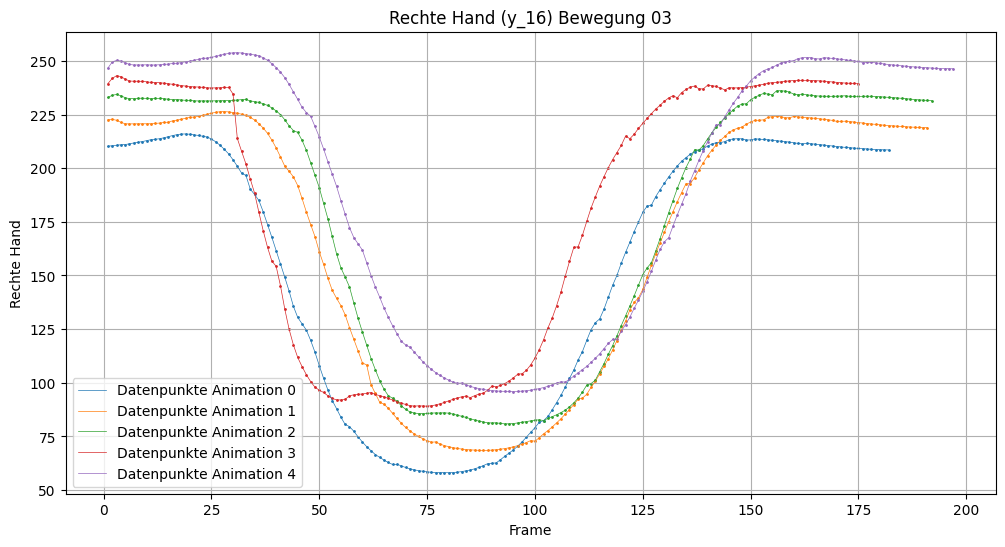

In [580]:
plt.figure(figsize=(12, 6))
for i, df in enumerate(dfs):
    plt.scatter(df["frame"], df["y_16"], marker='o', color=f'C{i}', s=1)
    plt.plot(df["frame"], df["y_16"], color=f'C{i}', linestyle='-', linewidth=0.5, label=f'Datenpunkte Animation {i}')

plt.title("Rechte Hand (y_16) Bewegung 03")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend(loc='best')
plt.show()

#### 1.3.1 Berechnung des Mean

In [581]:
means03 = []
mean_values_03 = df_deepM_03[['frame', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3', 'y_3', 'z_3',
                   'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5', 'x_6', 'y_6', 'z_6', 'x_7', 'y_7', 'z_7',
                   'x_8', 'y_8', 'z_8', 'x_9', 'y_9', 'z_9', 'x_10', 'y_10', 'z_10', 'x_11', 'y_11', 'z_11',
                   'x_12', 'y_12', 'z_12', 'x_13', 'y_13', 'z_13', 'x_14', 'y_14', 'z_14', 'x_15', 'y_15', 'z_15',
                   'x_16', 'y_16', 'z_16', 'x_17', 'y_17', 'z_17', 'x_18', 'y_18', 'z_18', 'x_19', 'y_19', 'z_19',
                   'x_20', 'y_20', 'z_20', 'x_21', 'y_21', 'z_21', 'x_22', 'y_22', 'z_22', 'x_23', 'y_23', 'z_23',
                   'x_24', 'y_24', 'z_24', 'x_25', 'y_25', 'z_25', 'x_26', 'y_26', 'z_26', 'x_27', 'y_27', 'z_27',
                   'x_28', 'y_28', 'z_28', 'x_29', 'y_29', 'z_29', 'x_30', 'y_30', 'z_30', 'x_31', 'y_31', 'z_31',
                   'x_32', 'y_32', 'z_32']].groupby('frame').mean()
means03.append(mean_values_03)
    
mean_values_03.head(5)

x_0       y_0         z_0       x_1       y_1       z_1       x_2   
frame                                                                           
1      65.99356  18.27286 -171.467506 -993.7168 -312.4525 -60.97508 -993.7168  \
2      66.85646  19.80700 -171.254204 -993.7168 -312.4525 -60.97508 -993.7168   
3      67.98854  20.18948 -170.908414 -993.7168 -312.4525 -60.97508 -993.7168   
4      68.69194  19.89282 -170.505374 -993.7168 -312.4525 -60.97508 -993.7168   
5      69.62770  19.35010 -170.065084 -993.7168 -312.4525 -60.97508 -993.7168   

            y_2       z_2       x_3  ...      z_29      x_30      y_30   
frame                                ...                                 
1     -312.4525 -60.97508 -993.7168  ... -60.97508 -993.7168 -312.4525  \
2     -312.4525 -60.97508 -993.7168  ... -60.97508 -993.7168 -312.4525   
3     -312.4525 -60.97508 -993.7168  ... -60.97508 -993.7168 -312.4525   
4     -312.4525 -60.97508 -993.7168  ... -60.97508 -993.7168 -312.4525   
5     -312.4525 -60.97508 -993.7168  ... -60.97508 -993.7168 -312.4525   

           z_30      x_31      y_31        z_31      x_32      y_32   
frame                                                                 
1     -60.97508  154.4078  805.5755 -255.696504  72.54712  806.6257  \
2     -60.97508  154.3102  807.3189 -255.160410  72.41398  808.1503   
3     -60.97508  154.0066  807.8827 -254.986212  72.10524  808.3263   
4     -60.97508  154.3780  807.6317 -255.097998  72.50384  807.9017   
5     -60.97508  154.3640  807.1665 -255.087324  72.51816  807.2171   

             z_32  
frame              
1     -255.794900  
2     -255.459556  
3     -255.291174  
4     -256.291508  
5     -256.741820  

[5 rows x 99 columns]

#### 1.3.2 Bewegungsmuster mit Mean

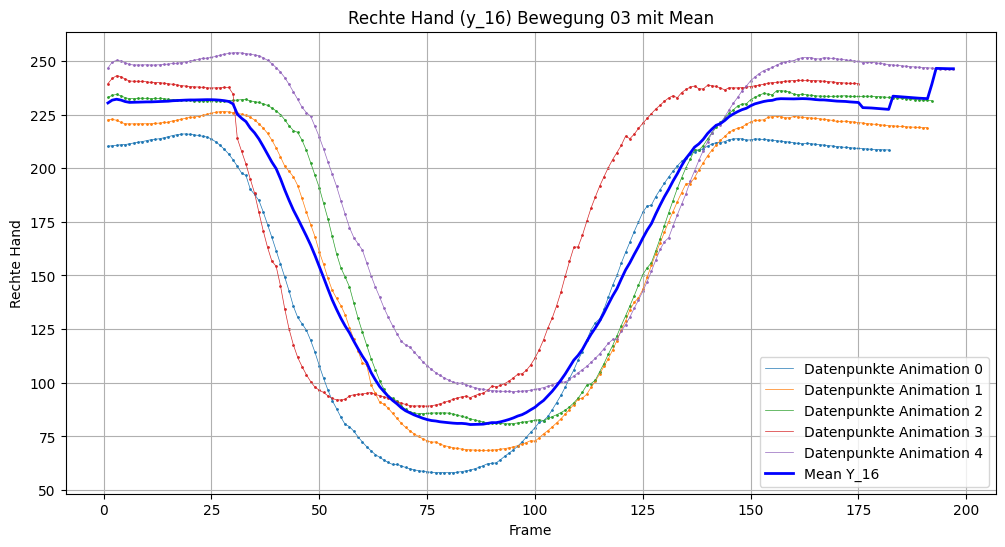

In [582]:
plt.figure(figsize=(12, 6))

for i, df in enumerate(dfs):
    plt.scatter(df["frame"], df["y_16"], marker='o', color=f'C{i}', s=1)
    plt.plot(df["frame"], df["y_16"], color=f'C{i}', linestyle='-', linewidth=0.5, label=f'Datenpunkte Animation {i}')

plt.plot(mean_values_03.index, mean_values_03["y_16"], color='b', linestyle='-', linewidth=2, label='Mean Y_16')
plt.title("Rechte Hand (y_16) Bewegung 03 mit Mean")
plt.xlabel("Frame")
plt.legend(loc='best')
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.show()

## 2. DeepMotion Kompensiert 01

In [583]:
df_deepM01 = pd.read_csv('../Data/KeypointsBereinigtKompensiert_01.csv', sep=',', encoding='utf-8')
df_deepM01.head(5)

compensation  frame                                               path   
0             1      1  /Users/salomekoller/Library/CloudStorage/OneDr...  \
1             1      2  /Users/salomekoller/Library/CloudStorage/OneDr...   
2             1      3  /Users/salomekoller/Library/CloudStorage/OneDr...   
3             1      4  /Users/salomekoller/Library/CloudStorage/OneDr...   
4             1      5  /Users/salomekoller/Library/CloudStorage/OneDr...   

     x_0       x_1       x_2       x_3       x_4       x_5       x_6  ...   
0  0.000 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957  ...  \
1  1.909 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957  ...   
2  2.832 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957  ...   
3  3.748 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957  ...   
4  5.316 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957  ...   

        z_23       z_24      z_25      z_26       z_27       z_28      z_29   
0 -54.232452 -55.732347 -86.36791 -73.35297 -140.74894 -141.03328 -48.49379  \
1 -55.343797 -56.752106 -86.88588 -74.65325 -140.99239 -141.31013 -48.49379   
2 -55.947689 -57.295671 -87.15947 -75.24743 -140.94134 -141.37022 -48.49379   
3 -56.572451 -57.857934 -87.47403 -75.87163 -140.93407 -141.53690 -48.49379   
4 -57.970961 -59.166960 -88.48003 -77.44732 -141.46560 -142.56488 -48.49379   

       z_30      z_31      z_32  
0 -48.49379 -95.50346 -95.37153  
1 -48.49379 -95.63772 -95.59663  
2 -48.49379 -95.49199 -95.61985  
3 -48.49379 -95.39195 -95.76678  
4 -48.49379 -95.79207 -96.77919  

[5 rows x 102 columns]

### 2.1 Analyse Form

In [584]:
print('Dimension:', df_deepM01.shape)
print('Number of rows:', df_deepM01.shape[0])
print('Number of columns:', df_deepM01.shape[1])

Dimension: (1096, 102)
Number of rows: 1096
Number of columns: 102


### 2.2 Splitting Frames

In [585]:
# Variablen initiieren
frame_count = 0
frames_until_reset = []

# Iterieren über Dataframe, um Frames mit '1' zu finden
for index, row in df_deepM01.iterrows():
    frame_count += 1
    
    if row["frame"] == 1 and frame_count > 1:
        frames_until_reset.append(frame_count -1)

if frame_count > 0:
    frames_until_reset.append(frame_count)

print("Number of frames until reset for each cycle:", frames_until_reset)

Number of frames until reset for each cycle: [210, 431, 652, 873, 1096]


In [586]:
# Einzelne Bewegungen werden in verschiedene Dataframes gepackt
dfsKomp01 = []
start = 0
for end in frames_until_reset:
    dfsKomp01.append(df_deepM01.iloc[start:end])
    start = end

print("Number of splits:", len(dfsKomp01))

Number of splits: 5


### 2.3 Bewegungsanalyse anhand rechter Hand (Kompensiert 01)

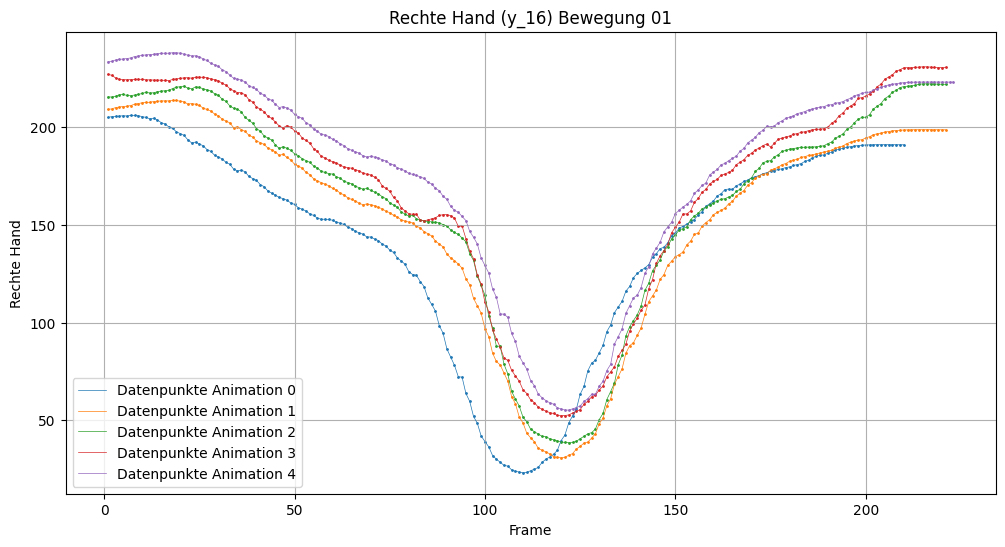

In [587]:
plt.figure(figsize=(12, 6)) 
for i, df in enumerate(dfsKomp01):
    plt.scatter(df["frame"], df["y_16"], marker='o', color=f'C{i}', s=1)
    plt.plot(df["frame"], df["y_16"], color=f'C{i}', linestyle='-', linewidth=0.5, label=f'Datenpunkte Animation {i}')

plt.title("Rechte Hand (y_16) Bewegung 01")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend(loc='best')
plt.show()


#### 2.3.1 Berechnung des Mean

In [588]:
means01 = []
mean_values_01 = df_deepM01[['frame', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3', 'y_3', 'z_3',
                   'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5', 'x_6', 'y_6', 'z_6', 'x_7', 'y_7', 'z_7',
                   'x_8', 'y_8', 'z_8', 'x_9', 'y_9', 'z_9', 'x_10', 'y_10', 'z_10', 'x_11', 'y_11', 'z_11',
                   'x_12', 'y_12', 'z_12', 'x_13', 'y_13', 'z_13', 'x_14', 'y_14', 'z_14', 'x_15', 'y_15', 'z_15',
                   'x_16', 'y_16', 'z_16', 'x_17', 'y_17', 'z_17', 'x_18', 'y_18', 'z_18', 'x_19', 'y_19', 'z_19',
                   'x_20', 'y_20', 'z_20', 'x_21', 'y_21', 'z_21', 'x_22', 'y_22', 'z_22', 'x_23', 'y_23', 'z_23',
                   'x_24', 'y_24', 'z_24', 'x_25', 'y_25', 'z_25', 'x_26', 'y_26', 'z_26', 'x_27', 'y_27', 'z_27',
                   'x_28', 'y_28', 'z_28', 'x_29', 'y_29', 'z_29', 'x_30', 'y_30', 'z_30', 'x_31', 'y_31', 'z_31',
                   'x_32', 'y_32', 'z_32']].groupby('frame').mean()
means01.append(mean_values_01)

mean_values_01.head(5)

x_0       y_0         z_0       x_1      y_1       z_1       x_2   
frame                                                                         
1      42.9238  16.61496 -200.431752 -1007.957 -310.477 -48.49379 -1007.957  \
2      44.8634  16.47286 -202.449376 -1007.957 -310.477 -48.49379 -1007.957   
3      46.3038  16.14494 -204.223192 -1007.957 -310.477 -48.49379 -1007.957   
4      47.5600  15.77780 -206.149102 -1007.957 -310.477 -48.49379 -1007.957   
5      49.5454  15.59410 -208.155064 -1007.957 -310.477 -48.49379 -1007.957   

           y_2       z_2       x_3  ...      z_29      x_30     y_30   
frame                               ...                                
1     -310.477 -48.49379 -1007.957  ... -48.49379 -1007.957 -310.477  \
2     -310.477 -48.49379 -1007.957  ... -48.49379 -1007.957 -310.477   
3     -310.477 -48.49379 -1007.957  ... -48.49379 -1007.957 -310.477   
4     -310.477 -48.49379 -1007.957  ... -48.49379 -1007.957 -310.477   
5     -310.477 -48.49379 -1007.957  ... -48.49379 -1007.957 -310.477   

           z_30      x_31      y_31        z_31      x_32      y_32   
frame                                                                 
1     -48.49379  108.7978  804.2580 -310.868084  27.40192  805.4124  \
2     -48.49379  108.1234  804.7362 -310.319296  26.74318  805.4902   
3     -48.49379  108.0088  804.9022 -309.836790  26.64796  805.4070   
4     -48.49379  108.8146  804.7238 -311.051902  27.48648  805.1952   
5     -48.49379  108.6924  805.0104 -311.115766  27.35456  805.2414   

             z_32  
frame              
1     -303.746878  
2     -303.127498  
3     -302.555662  
4     -303.530168  
5     -303.624450  

[5 rows x 99 columns]

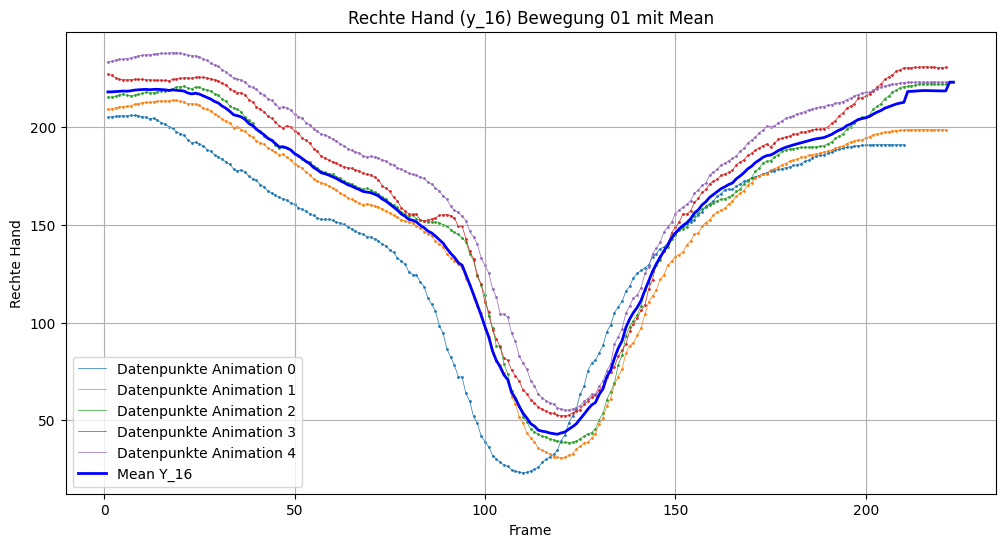

In [589]:
plt.figure(figsize=(12, 6))

for i, df in enumerate(dfsKomp01):
    plt.scatter(df["frame"], df["y_16"], marker='o', color=f'C{i}', s=1)
    plt.plot(df["frame"], df["y_16"], color=f'C{i}', linestyle='-', linewidth=0.5, label=f'Datenpunkte Animation {i}')

plt.plot(mean_values_01.index, mean_values_01["y_16"], color='b', linestyle='-', linewidth=2, label='Mean Y_16')

plt.title("Rechte Hand (y_16) Bewegung 01 mit Mean")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend(loc='best')
plt.show()

### 2.4 Bewegungsanalyse linker Ellbogen (Kompensiert 01)

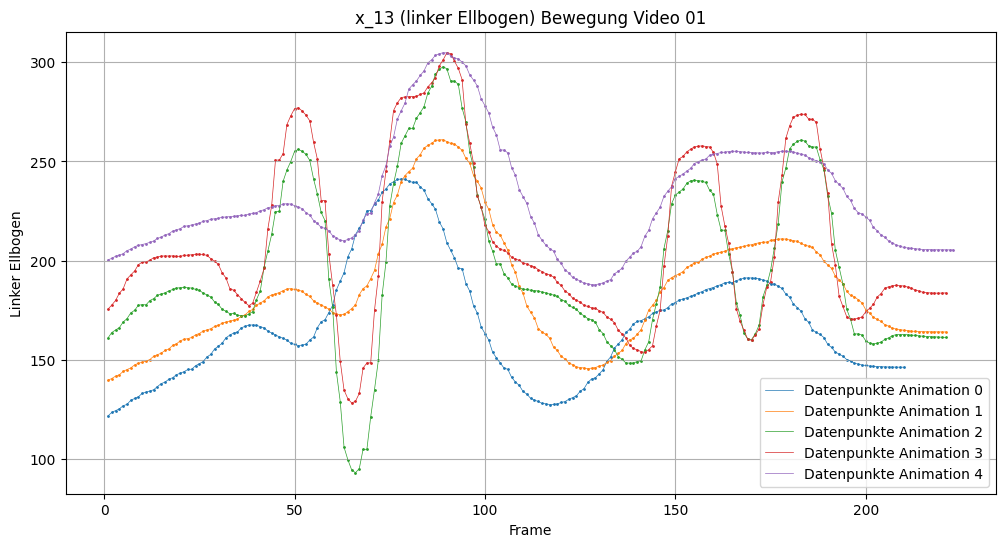

In [590]:
plt.figure(figsize=(12, 6)) 
for i, df in enumerate(dfsKomp01):
    plt.scatter(df["frame"], df["x_13"], marker='o', color=f'C{i}', s=1)
    plt.plot(df["frame"], df["x_13"], color=f'C{i}', linestyle='-', linewidth=0.5, label=f'Datenpunkte Animation {i}')

plt.title("x_13 (linker Ellbogen) Bewegung Video 01")
plt.xlabel("Frame")
plt.ylabel("Linker Ellbogen")
plt.grid(True)
plt.legend(loc='best')
plt.show()

## 3. DeepMotion Kompensiert 02

In [591]:
df_deepM02 = pd.read_csv('../Data/KeypointsBereinigtKompensiert_02.csv', sep=',', encoding='utf-8')
df_deepM02.head(5)

compensation  frame                                               path   
0             1      1  /Users/salomekoller/Library/CloudStorage/OneDr...  \
1             1      2  /Users/salomekoller/Library/CloudStorage/OneDr...   
2             1      3  /Users/salomekoller/Library/CloudStorage/OneDr...   
3             1      4  /Users/salomekoller/Library/CloudStorage/OneDr...   
4             1      5  /Users/salomekoller/Library/CloudStorage/OneDr...   

      x_0       x_1       x_2       x_3       x_4       x_5       x_6  ...   
0   0.000 -1045.738 -1045.738 -1045.738 -1045.738 -1045.738 -1045.738  ...  \
1   5.366 -1045.738 -1045.738 -1045.738 -1045.738 -1045.738 -1045.738  ...   
2   8.136 -1045.738 -1045.738 -1045.738 -1045.738 -1045.738 -1045.738  ...   
3  13.775 -1045.738 -1045.738 -1045.738 -1045.738 -1045.738 -1045.738  ...   
4  15.967 -1045.738 -1045.738 -1045.738 -1045.738 -1045.738 -1045.738  ...   

       z_23      z_24      z_25       z_26       z_27      z_28      z_29   
0 -37.69084 -28.31890 -38.89564 -45.227116 -101.69009 -89.82048 -53.49067  \
1 -33.65205 -24.53783 -35.95330 -44.349021 -101.89741 -89.62951 -53.49067   
2 -31.50526 -22.53382 -34.32710 -43.744561 -101.77919 -89.61607 -53.49067   
3 -26.93351 -18.24678 -30.77586 -42.135530 -100.91355 -89.55945 -53.49067   
4 -24.44174 -15.80145 -28.45445 -40.110030  -99.01383 -87.68407 -53.49067   

       z_30       z_31      z_32  
0 -53.49067 -53.797332 -41.81292  
1 -53.49067 -54.520770 -42.03391  
2 -53.49067 -54.623282 -42.25433  
3 -53.49067 -54.088738 -42.71065  
4 -53.49067 -52.258401 -40.89253  

[5 rows x 102 columns]

### 3.1 Analyse Form

In [592]:
print('Dimension:', df_deepM02.shape)
print('Number of rows:', df_deepM02.shape[0])
print('Number of columns:', df_deepM02.shape[1])

Dimension: (1715, 102)
Number of rows: 1715
Number of columns: 102


### 3.2 Splitting Frames

In [593]:
# Variablen initiieren
frame_count = 0
frames_until_reset = []

# Iterieren über Dataframe, um Frames mit '1' zu finden
for index, row in df_deepM02.iterrows():
    frame_count += 1

    if row["frame"] == 1 and frame_count > 1:
        frames_until_reset.append(frame_count -1)

if frame_count > 0:
    frames_until_reset.append(frame_count)

print("Number of frames until reset for each cycle:", frames_until_reset)

Number of frames until reset for each cycle: [337, 676, 1019, 1366, 1715]


In [594]:
# Einzelne Bewegungen werden in verschiedene Dataframes gepackt
dfsKomp02 = []
start = 0
for end in frames_until_reset:
    dfsKomp02.append(df_deepM02.iloc[start:end])
    start = end

print("Number of splits:", len(dfsKomp02))

Number of splits: 5


### 3.3 Bewegungsanalyse anhand rechter Handbewegung (Kompensiert 02)

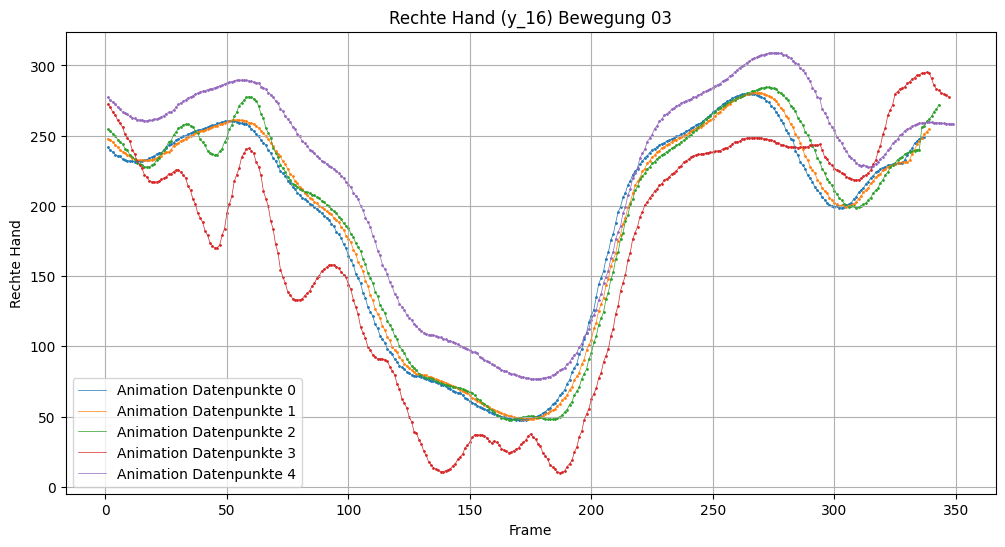

In [595]:
plt.figure(figsize=(12, 6)) 

for i, df in enumerate(dfsKomp02):

    plt.scatter(df["frame"], df["y_16"], marker='o', color=f'C{i}', s=1)
    plt.plot(df["frame"], df["y_16"], color=f'C{i}', linestyle='-', linewidth=0.5, label=f'Animation Datenpunkte {i}')

plt.title("Rechte Hand (y_16) Bewegung 03")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend(loc='best')
plt.show()

#### 3.3.1 Berechnung des Mean

In [596]:
means02 = []
mean_values_02 = df_deepM02[['frame', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3', 'y_3', 'z_3',
                   'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5', 'x_6', 'y_6', 'z_6', 'x_7', 'y_7', 'z_7',
                   'x_8', 'y_8', 'z_8', 'x_9', 'y_9', 'z_9', 'x_10', 'y_10', 'z_10', 'x_11', 'y_11', 'z_11',
                   'x_12', 'y_12', 'z_12', 'x_13', 'y_13', 'z_13', 'x_14', 'y_14', 'z_14', 'x_15', 'y_15', 'z_15',
                   'x_16', 'y_16', 'z_16', 'x_17', 'y_17', 'z_17', 'x_18', 'y_18', 'z_18', 'x_19', 'y_19', 'z_19',
                   'x_20', 'y_20', 'z_20', 'x_21', 'y_21', 'z_21', 'x_22', 'y_22', 'z_22', 'x_23', 'y_23', 'z_23',
                   'x_24', 'y_24', 'z_24', 'x_25', 'y_25', 'z_25', 'x_26', 'y_26', 'z_26', 'x_27', 'y_27', 'z_27',
                   'x_28', 'y_28', 'z_28', 'x_29', 'y_29', 'z_29', 'x_30', 'y_30', 'z_30', 'x_31', 'y_31', 'z_31',
                   'x_32', 'y_32', 'z_32']].groupby('frame').mean()
means02.append(mean_values_02)
    
mean_values_02.head(5)

x_0       y_0         z_0       x_1       y_1       z_1       x_2   
frame                                                                           
1     -80.50884   8.62712 -102.583294 -1045.738 -307.2164 -53.49067 -1045.738  \
2     -77.81076   8.94612  -98.155338 -1045.738 -307.2164 -53.49067 -1045.738   
3     -75.21866   9.22386  -93.563912 -1045.738 -307.2164 -53.49067 -1045.738   
4     -72.21568   9.81578  -88.551916 -1045.738 -307.2164 -53.49067 -1045.738   
5     -69.32478  10.38222  -82.843140 -1045.738 -307.2164 -53.49067 -1045.738   

            y_2       z_2       x_3  ...      z_29      x_30      y_30   
frame                                ...                                 
1     -307.2164 -53.49067 -1045.738  ... -53.49067 -1045.738 -307.2164  \
2     -307.2164 -53.49067 -1045.738  ... -53.49067 -1045.738 -307.2164   
3     -307.2164 -53.49067 -1045.738  ... -53.49067 -1045.738 -307.2164   
4     -307.2164 -53.49067 -1045.738  ... -53.49067 -1045.738 -307.2164   
5     -307.2164 -53.49067 -1045.738  ... -53.49067 -1045.738 -307.2164   

           z_30      x_31       y_31       z_31       x_32      y_32   
frame                                                                  
1     -53.49067 -26.06254  771.53252 -85.387361 -208.51494  781.1454  \
2     -53.49067 -26.57306  772.13808 -85.759563 -208.38156  780.9080   
3     -53.49067 -27.16772  772.94482 -86.051667 -208.08650  780.7230   
4     -53.49067 -27.28626  772.99346 -86.090571 -208.09140  780.6738   
5     -53.49067 -26.90568  773.14880 -85.860668 -207.84652  780.6538   

             z_32  
frame              
1     -110.230288  
2     -110.333784  
3     -110.410921  
4     -110.657255  
5     -110.558228  

[5 rows x 99 columns]

#### 3.3.2 Bewegungsmuster mit Mean

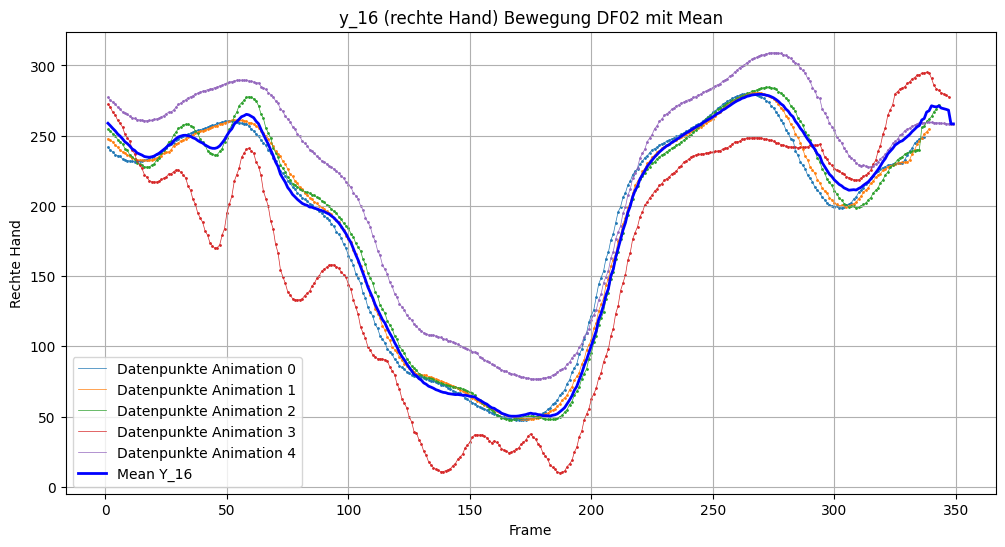

In [597]:
plt.figure(figsize=(12, 6))

for i, df in enumerate(dfsKomp02):

    plt.scatter(df["frame"], df["y_16"], marker='o', color=f'C{i}', s=1)
    plt.plot(df["frame"], df["y_16"], color=f'C{i}', linestyle='-', linewidth=0.5, label=f'Datenpunkte Animation {i}')

plt.plot(mean_values_02.index, mean_values_02["y_16"], color='b', linestyle='-', linewidth=2, label='Mean Y_16')

plt.title("y_16 (rechte Hand) Bewegung DF02 mit Mean" )
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend(loc='best')
plt.show()

## 4. MediaPipe

In [598]:
df_MediaP = pd.read_csv('../Data/samples.csv', sep=',', encoding='utf-8')
df_MediaP.head(5)

path  frame  compensation   
0  bachelorarbeiten/nils/data/videos/samples/drin...      1         False  \
1  bachelorarbeiten/nils/data/videos/samples/drin...      2         False   
2  bachelorarbeiten/nils/data/videos/samples/drin...      3         False   
3  bachelorarbeiten/nils/data/videos/samples/drin...      4         False   
4  bachelorarbeiten/nils/data/videos/samples/drin...      5         False   

       x_0      y_0        z_0       x_1       y_1         z_1       x_2  ...   
0  0.00000  0.00000    0.00000  20.93640 -23.58810   67.128800  32.30596  ...  \
1 -0.08766  0.51810   61.53380  20.51320 -23.60074  137.915300  31.65790  ...   
2 -0.81886  0.99103  143.05466  19.41430 -23.59127  218.420940  30.26354  ...   
3 -1.46955  1.41806  349.09104  18.92890 -23.51630  419.324940  29.69970  ...   
4 -2.07000  1.49976  450.38204  18.47704 -23.52460  517.691055  29.29530  ...   

        z_29       x_30       y_30        z_30      x_31       y_31   
0   28.99000 -111.31410  500.86573   212.30550  149.0010  443.31818  \
1  144.98176 -117.10200  628.15216   390.75823  107.9158  509.11103   
2  130.40780 -123.36020  642.35313   494.83884   86.0822  602.66028   
3  346.76520 -123.25700  662.83948  1253.09060  101.4250  643.70493   
4  -31.00470 -117.32246  701.49013   -67.27220   74.0153  634.92139   

        z_31       x_32       y_32       z_32  
0 -183.80580 -106.19807  468.39473   35.82680  
1 -100.04770 -116.11866  605.60577  130.99010  
2 -130.16710 -120.94795  653.28283  192.77330  
3   54.78520 -118.50544  716.12153  986.52970  
4 -238.75634 -111.79520  682.78198 -297.20605  

[5 rows x 102 columns]

### 4.1 Analyse form

In [599]:
print('Dimension:', df_MediaP.shape)
print('Number of rows:', df_MediaP.shape[0])
print('Number of columns:', df_MediaP.shape[1])

Dimension: (623, 102)
Number of rows: 623
Number of columns: 102


### 4.2 Splitting Frames

In [600]:
# Variablen initiieren
frame_count = 0
frames_until_reset = []

# Iterieren über Dataframe, um Frames mit '1' zu finden
for index, row in df_MediaP.iterrows():
    frame_count += 1
    
    if row["frame"] == 1 and frame_count > 1:
        frames_until_reset.append(frame_count -1)

if frame_count > 0:
    frames_until_reset.append(frame_count)

print("Number of frames until reset for each cycle:", frames_until_reset)

Number of frames until reset for each cycle: [172, 471, 623]


In [601]:
# DataFrame entsprechend splitten
df_MediaP1 = df_MediaP.iloc[:frames_until_reset[0]]
df_MediaP2 = df_MediaP.iloc[frames_until_reset[0]:frames_until_reset[1]]
df_MediaP3 = df_MediaP.iloc[frames_until_reset[1]:]

In [602]:
df_MediaP1.head(5)

path  frame  compensation   
0  bachelorarbeiten/nils/data/videos/samples/drin...      1         False  \
1  bachelorarbeiten/nils/data/videos/samples/drin...      2         False   
2  bachelorarbeiten/nils/data/videos/samples/drin...      3         False   
3  bachelorarbeiten/nils/data/videos/samples/drin...      4         False   
4  bachelorarbeiten/nils/data/videos/samples/drin...      5         False   

       x_0      y_0        z_0       x_1       y_1         z_1       x_2  ...   
0  0.00000  0.00000    0.00000  20.93640 -23.58810   67.128800  32.30596  ...  \
1 -0.08766  0.51810   61.53380  20.51320 -23.60074  137.915300  31.65790  ...   
2 -0.81886  0.99103  143.05466  19.41430 -23.59127  218.420940  30.26354  ...   
3 -1.46955  1.41806  349.09104  18.92890 -23.51630  419.324940  29.69970  ...   
4 -2.07000  1.49976  450.38204  18.47704 -23.52460  517.691055  29.29530  ...   

        z_29       x_30       y_30        z_30      x_31       y_31   
0   28.99000 -111.31410  500.86573   212.30550  149.0010  443.31818  \
1  144.98176 -117.10200  628.15216   390.75823  107.9158  509.11103   
2  130.40780 -123.36020  642.35313   494.83884   86.0822  602.66028   
3  346.76520 -123.25700  662.83948  1253.09060  101.4250  643.70493   
4  -31.00470 -117.32246  701.49013   -67.27220   74.0153  634.92139   

        z_31       x_32       y_32       z_32  
0 -183.80580 -106.19807  468.39473   35.82680  
1 -100.04770 -116.11866  605.60577  130.99010  
2 -130.16710 -120.94795  653.28283  192.77330  
3   54.78520 -118.50544  716.12153  986.52970  
4 -238.75634 -111.79520  682.78198 -297.20605  

[5 rows x 102 columns]

### 4.3.1 Vergleich Länge Mediapipe Frame zu DeepMotion Frame 01

In [603]:
print('Dimension MediaPipe02:', df_MediaP1.shape)

for i, df in enumerate(dfsKomp01):
    print(f"DataFrame {i+1} Shape:", df.shape)

Dimension MediaPipe02: (172, 102)
DataFrame 1 Shape: (210, 102)
DataFrame 2 Shape: (221, 102)
DataFrame 3 Shape: (221, 102)
DataFrame 4 Shape: (221, 102)
DataFrame 5 Shape: (223, 102)


In [604]:
df_MediaP2.head(5)

path  frame  compensation   
172  bachelorarbeiten/nils/data/videos/samples/03_t...      1         False  \
173  bachelorarbeiten/nils/data/videos/samples/03_t...      2         False   
174  bachelorarbeiten/nils/data/videos/samples/03_t...      3         False   
175  bachelorarbeiten/nils/data/videos/samples/03_t...      4         False   
176  bachelorarbeiten/nils/data/videos/samples/03_t...      5         False   

         x_0      y_0       z_0       x_1       y_1       z_1       x_2  ...   
172  0.00000  0.00000   0.00000  17.38537 -29.99744  56.25369  27.63987  ...  \
173  0.13657  1.86088   0.74194  18.02587 -28.65700  60.68301  28.19997  ...   
174  0.19873  4.28568 -32.74405  18.46667 -26.17262  27.21961  28.57457  ...   
175  1.98133  5.42386 -47.27786  20.62547 -24.82529  13.32980  30.66807  ...   
176  3.43781  7.83182 -78.69376  22.50047 -22.28963 -18.95038  32.54467  ...   

           z_29       x_30       y_30        z_30      x_31       y_31   
172  389.815213 -103.06396  921.50588  301.479875  26.01737  940.00918  \
173  354.447420  -99.65853  919.31528  258.856070  21.88357  934.34318   
174  345.782710  -97.71463  917.85738  255.230180  18.80967  932.54098   
175  345.342835  -97.21393  918.55368  233.353210  18.55587  930.39268   
176  349.146360  -97.13253  917.03108  245.270220  18.68847  925.58078   

          z_31       x_32       y_32      z_32  
172  181.40444 -154.66107  998.00808  41.57214  
173  124.78337 -143.04223  997.20708 -25.92605  
174  114.25787 -137.98089  996.87218 -27.56421  
175  111.29385 -138.31183  998.13368 -61.29733  
176  122.71460 -138.50677  997.46798 -37.73511  

[5 rows x 102 columns]

### 4.3.2 Vergleich Länge Mediapipe Frame zu DeepMotion Frame 02

In [605]:
print('Dimension MediaPipe02:', df_MediaP2.shape)

for i, df in enumerate(dfsKomp02):
    print(f"DataFrame {i+1} Shape:", df.shape)

Dimension MediaPipe02: (299, 102)
DataFrame 1 Shape: (337, 102)
DataFrame 2 Shape: (339, 102)
DataFrame 3 Shape: (343, 102)
DataFrame 4 Shape: (347, 102)
DataFrame 5 Shape: (349, 102)


In [606]:
df_MediaP3.head(5)

path  frame  compensation   
471  bachelorarbeiten/nils/data/videos/samples/drin...      1         False  \
472  bachelorarbeiten/nils/data/videos/samples/drin...      2         False   
473  bachelorarbeiten/nils/data/videos/samples/drin...      3         False   
474  bachelorarbeiten/nils/data/videos/samples/drin...      4         False   
475  bachelorarbeiten/nils/data/videos/samples/drin...      5         False   

        x_0      y_0        z_0       x_1       y_1        z_1      x_2  ...   
471  0.0000  0.00000    0.00000  22.24680 -24.15484   65.92985  34.8689  ...  \
472 -0.6283  0.01216 -301.26235  21.56970 -24.26059 -240.94045  33.8579  ...   
473 -0.7909  0.08472 -292.39315  21.42860 -24.49930 -233.72395  33.4548  ...   
474 -1.8517 -0.03454 -172.72809  20.84754 -25.05017 -114.56159  32.8417  ...   
475 -1.7632  0.03699 -145.25145  20.90534 -25.24734  -90.44129  32.8452  ...   

           z_29       x_30        y_30        z_30     x_31        y_31   
471   145.00479 -147.09710   771.05986   982.87658  55.2638   778.19426  \
472  1194.78405 -135.65660   993.49076  1673.93625  74.9789  1043.78316   
473  1278.60760 -135.40540  1035.81876  1704.44805  72.3245  1097.42196   
474  1410.71525 -128.04266  1065.27046  1651.87315  40.1091  1118.78446   
475  1279.34845 -126.30810  1065.57436  1570.90455  41.4844  1120.65646   

           z_31       x_32        y_32        z_32  
471  -150.90949 -176.13980   815.11506   717.95263  
472   864.69295 -146.78870  1035.35836  1328.61279  
473   955.37579 -136.04710  1076.70566  1362.04315  
474  1110.88085 -113.48285  1106.16356  1334.27275  
475   990.85065 -110.82043  1107.35976  1267.89721  

[5 rows x 102 columns]

### 4.3.3 Vergleich Länge Mediapipe Frame zu DeepMotion Frame 03

In [607]:
print('Dimension MediaPipe03:', df_MediaP3.shape)

for i, df in enumerate(dfs):
    print(f"DataFrame {i+1} Shape:", df.shape)

Dimension MediaPipe03: (152, 102)
DataFrame 1 Shape: (182, 102)
DataFrame 2 Shape: (191, 102)
DataFrame 3 Shape: (192, 102)
DataFrame 4 Shape: (175, 102)
DataFrame 5 Shape: (197, 102)


### 4.4 Rechter Arm (z_16) Bewegung Mediapipe

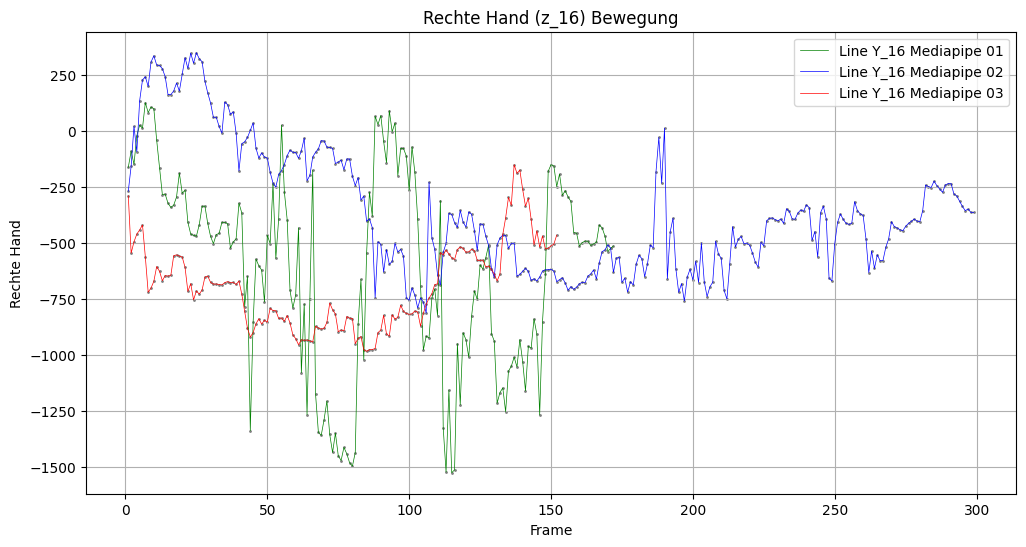

In [608]:
plt.figure(figsize=(12, 6))

plt.scatter(df_MediaP1["frame"], df_MediaP1["z_16"], marker='o', color='gray', s=1)
plt.plot(df_MediaP1["frame"], df_MediaP1["z_16"], color='green', linestyle='-', linewidth=0.5, label='Line Y_16 Mediapipe 01')

plt.scatter(df_MediaP2["frame"], df_MediaP2["z_16"], marker='o', color='gray', s=1)
plt.plot(df_MediaP2["frame"], df_MediaP2["z_16"], color='blue', linestyle='-', linewidth=0.5, label='Line Y_16 Mediapipe 02')

plt.scatter(df_MediaP3["frame"], df_MediaP3["z_16"], marker='o', color='gray', s=1)
plt.plot(df_MediaP3["frame"], df_MediaP3["z_16"], color='red', linestyle='-', linewidth=0.5, label='Line Y_16 Mediapipe 03')


plt.title("Rechte Hand (z_16) Bewegung")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend(loc='best')

plt.show()

### 4.5 Kopfbewegung (z_0) Mediapipe

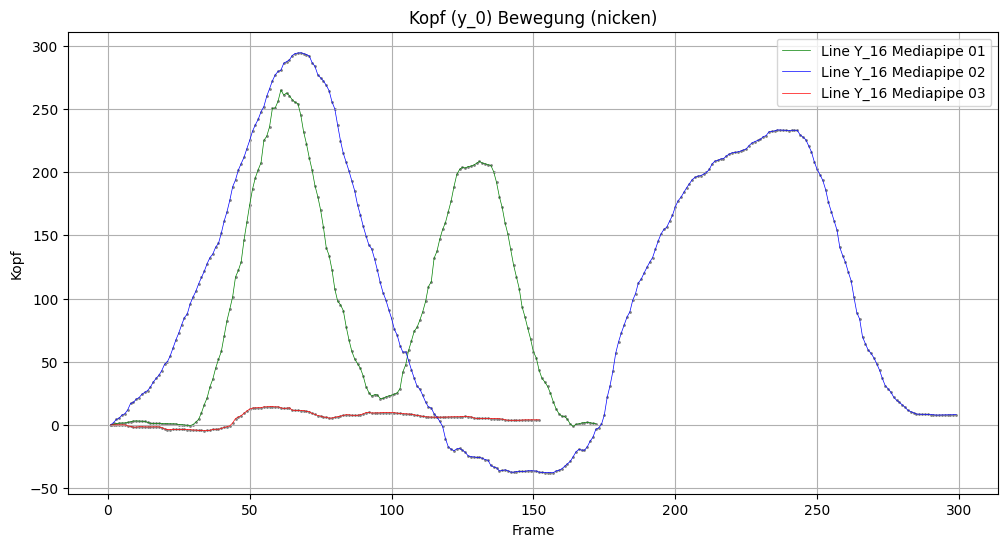

In [609]:
plt.figure(figsize=(12, 6)) 

plt.scatter(df_MediaP1["frame"], df_MediaP1["y_0"], marker='o', color='gray', s=1)
plt.plot(df_MediaP1["frame"], df_MediaP1["y_0"], color='green', linestyle='-', linewidth=0.5, label='Line Y_16 Mediapipe 01')

plt.scatter(df_MediaP2["frame"], df_MediaP2["y_0"], marker='o', color='gray', s=1)
plt.plot(df_MediaP2["frame"], df_MediaP2["y_0"], color='blue', linestyle='-', linewidth=0.5, label='Line Y_16 Mediapipe 02')

plt.scatter(df_MediaP3["frame"], df_MediaP3["y_0"], marker='o', color='gray', s=1)
plt.plot(df_MediaP3["frame"], df_MediaP3["y_0"], color='red', linestyle='-', linewidth=0.5, label='Line Y_16 Mediapipe 03')


plt.title("Kopf (y_0) Bewegung (nicken)")
plt.xlabel("Frame")
plt.ylabel("Kopf")
plt.grid(True)
# Move the legend outside of the plot
plt.legend(loc='best')

plt.show()

### 4.6 Bewegungsanalyse anhand rechter Handbewegung

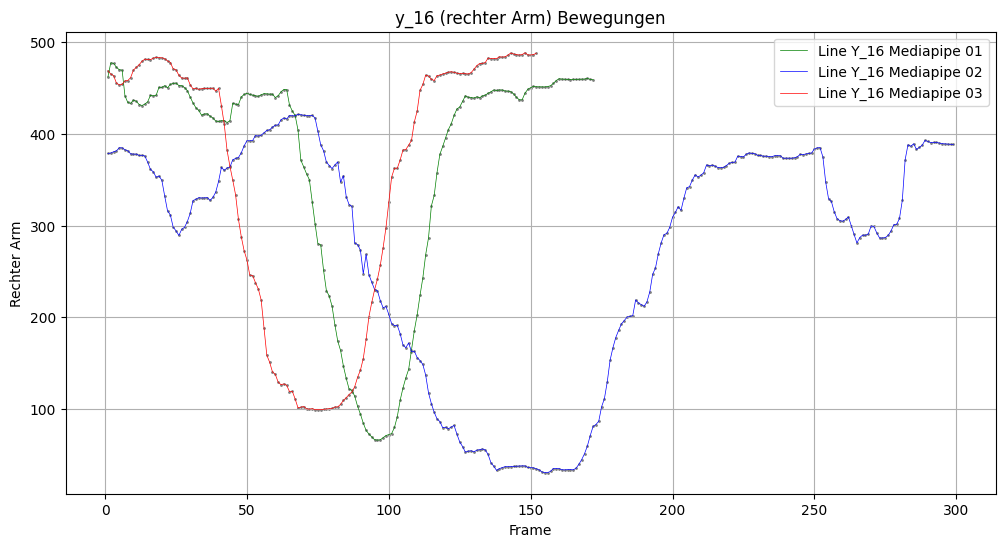

In [610]:
plt.figure(figsize=(12, 6))  

plt.scatter(df_MediaP1["frame"], df_MediaP1["y_16"], marker='o', color='gray', s=1)
plt.plot(df_MediaP1["frame"], df_MediaP1["y_16"], color='green', linestyle='-', linewidth=0.5, label='Line Y_16 Mediapipe 01')

plt.scatter(df_MediaP2["frame"], df_MediaP2["y_16"], marker='o', color='gray', s=1)
plt.plot(df_MediaP2["frame"], df_MediaP2["y_16"], color='blue', linestyle='-', linewidth=0.5, label='Line Y_16 Mediapipe 02')

plt.scatter(df_MediaP3["frame"], df_MediaP3["y_16"], marker='o', color='gray', s=1)
plt.plot(df_MediaP3["frame"], df_MediaP3["y_16"], color='red', linestyle='-', linewidth=0.5, label='Line Y_16 Mediapipe 03')


plt.title("y_16 (rechter Arm) Bewegungen")
plt.xlabel("Frame")
plt.ylabel("Rechter Arm")
plt.grid(True)
plt.legend(loc='best')
plt.show()

#### 4.6.1 Berechnung des Mean

In [611]:
meansMP = []
df_MediaP12 = pd.concat([df_MediaP1, df_MediaP2])

mean_values_MP = df_MediaP12[['frame', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3', 'y_3', 'z_3',
                   'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5', 'x_6', 'y_6', 'z_6', 'x_7', 'y_7', 'z_7',
                   'x_8', 'y_8', 'z_8', 'x_9', 'y_9', 'z_9', 'x_10', 'y_10', 'z_10', 'x_11', 'y_11', 'z_11',
                   'x_12', 'y_12', 'z_12', 'x_13', 'y_13', 'z_13', 'x_14', 'y_14', 'z_14', 'x_15', 'y_15', 'z_15',
                   'x_16', 'y_16', 'z_16', 'x_17', 'y_17', 'z_17', 'x_18', 'y_18', 'z_18', 'x_19', 'y_19', 'z_19',
                   'x_20', 'y_20', 'z_20', 'x_21', 'y_21', 'z_21', 'x_22', 'y_22', 'z_22', 'x_23', 'y_23', 'z_23',
                   'x_24', 'y_24', 'z_24', 'x_25', 'y_25', 'z_25', 'x_26', 'y_26', 'z_26', 'x_27', 'y_27', 'z_27',
                   'x_28', 'y_28', 'z_28', 'x_29', 'y_29', 'z_29', 'x_30', 'y_30', 'z_30', 'x_31', 'y_31', 'z_31',
                   'x_32', 'y_32', 'z_32']].groupby('frame').mean()
meansMP.append(mean_values_MP)
    
mean_values_MP.head(5)

x_0       y_0         z_0        x_1        y_1         z_1   
frame                                                                     
1      0.000000  0.000000    0.000000  19.160885 -26.792770   61.691245  \
2      0.024455  1.189490   31.137870  19.269535 -26.128870   99.299155   
3     -0.310065  2.638355   55.155305  18.940485 -24.881945  122.820275   
4      0.255890  3.420960  150.906590  19.777185 -24.170795  216.327370   
5      0.683905  4.665790  185.844140  20.488755 -22.907115  249.370338   

             x_2        y_2         z_2        x_3  ...        z_29   
frame                                               ...               
1      29.972915 -26.719330   61.493435  39.138005  ...  209.402607  \
2      29.928935 -26.037695   99.027580  39.343370  ...  249.714590   
3      29.419055 -24.742775  122.541585  38.976435  ...  238.095255   
4      30.183885 -24.029625  216.077535  39.729435  ...  346.054017   
5      30.919985 -22.769595  249.065295  40.560115  ...  159.070830   

             x_30        y_30        z_30       x_31        y_31       z_31   
frame                                                                         
1     -107.189030  711.185805  256.892687  87.509185  691.663680  -1.200680  \
2     -108.380265  773.733720  324.807150  64.899685  721.727105  12.367835   
3     -110.537415  780.105255  375.034510  52.445935  767.600630  -7.954615   
4     -110.235465  790.696580  743.221905  59.990435  787.048805  83.039525   
5     -107.227495  809.260605   88.999010  46.351885  780.251085 -58.020870   

             x_32        y_32        z_32  
frame                                      
1     -130.429570  733.201405   38.699470  
2     -129.580445  801.406425   52.532025  
3     -129.464420  825.077505   82.604545  
4     -128.408635  857.127605  462.616185  
5     -125.150985  840.124980 -167.470580  

[5 rows x 99 columns]

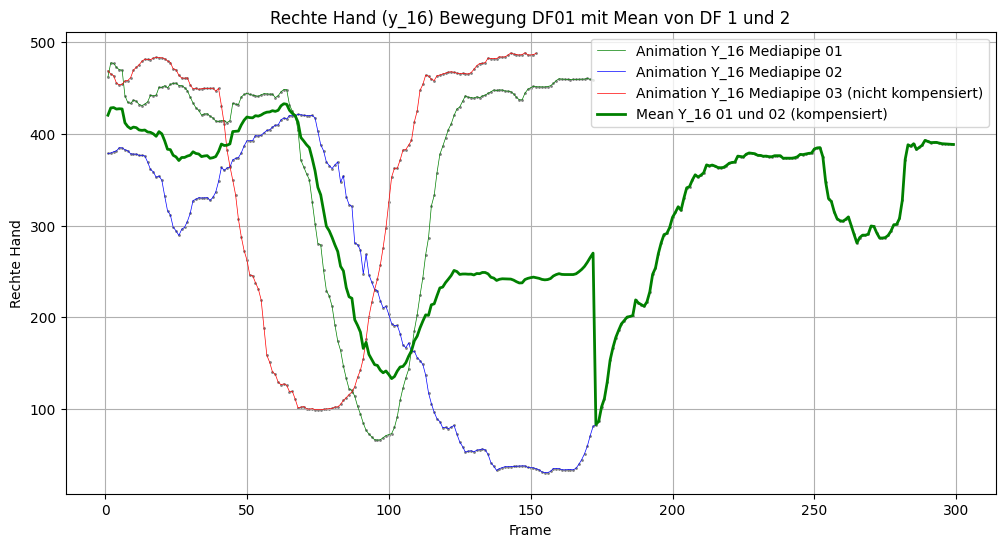

In [612]:
plt.figure(figsize=(12, 6))

plt.scatter(df_MediaP1["frame"], df_MediaP1["y_16"], marker='o', color='gray', s=1)
plt.plot(df_MediaP1["frame"], df_MediaP1["y_16"], color='green', linestyle='-', linewidth=0.5, label='Animation Y_16 Mediapipe 01')

plt.scatter(df_MediaP2["frame"], df_MediaP2["y_16"], marker='o', color='gray', s=1)
plt.plot(df_MediaP2["frame"], df_MediaP2["y_16"], color='blue', linestyle='-', linewidth=0.5, label='Animation Y_16 Mediapipe 02')

plt.scatter(df_MediaP3["frame"], df_MediaP3["y_16"], marker='o', color='gray', s=1)
plt.plot(df_MediaP3["frame"], df_MediaP3["y_16"], color='red', linestyle='-', linewidth=0.5, label='Animation Y_16 Mediapipe 03 (nicht kompensiert)')

plt.plot(mean_values_MP.index, mean_values_MP["y_16"], color='green', linestyle='-', linewidth=2, label='Mean Y_16 01 und 02 (kompensiert)')

plt.title("Rechte Hand (y_16) Bewegung DF01 mit Mean von DF 1 und 2")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend(loc='best')
plt.show()

# Berechnung Euclidean Distances

## 5. Analyse der Mean Werte

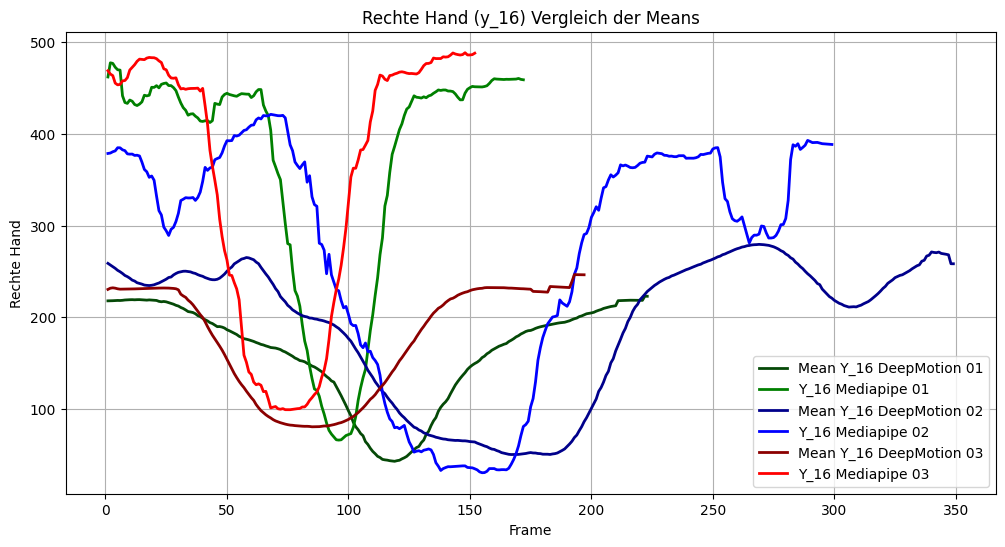

In [613]:
plt.figure(figsize=(12, 6))

plt.plot(mean_values_01.index, mean_values_01["y_16"], color='#054907', linestyle='-', linewidth=2, label='Mean Y_16 DeepMotion 01')
plt.plot(df_MediaP1["frame"], df_MediaP1["y_16"], color='green', linestyle='-', linewidth=2, label='Y_16 Mediapipe 01')

plt.plot(mean_values_02.index, mean_values_02["y_16"], color='darkblue', linestyle='-', linewidth=2, label='Mean Y_16 DeepMotion 02')
plt.plot(df_MediaP2["frame"], df_MediaP2["y_16"], color='blue', linestyle='-', linewidth=2, label='Y_16 Mediapipe 02')

plt.plot(mean_values_03.index, mean_values_03["y_16"], color='darkred', linestyle='-', linewidth=2, label='Mean Y_16 DeepMotion 03')
plt.plot(df_MediaP3["frame"], df_MediaP3["y_16"], color='red', linestyle='-', linewidth=2, label='Y_16 Mediapipe 03')

plt.title("Rechte Hand (y_16) Vergleich der Means")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [614]:
difference_in_mean_01 = df_MediaP1['y_16'].mean() - mean_values_01['y_16'].mean()
difference_in_mean_02 = df_MediaP2['y_16'].mean() - mean_values_02['y_16'].mean()
difference_in_mean_03 = df_MediaP3['y_16'].mean() - mean_values_03['y_16'].mean()

difference_in_mean_01_per = difference_in_mean_01 / df_MediaP1['y_16'].mean() * 100
difference_in_mean_02_per = difference_in_mean_02 / df_MediaP2['y_16'].mean() * 100
difference_in_mean_03_per = difference_in_mean_03 / df_MediaP3['y_16'].mean() * 100

print(f"Mean Value in DeepMotion 01: {mean_values_01['y_16'].mean()}")
print(f"Mean Value in MediaPipe 01: {df_MediaP1['y_16'].mean()}")
print(f"Difference in Mean: {difference_in_mean_01}")
print(f"Difference in Mean in Percentage: {difference_in_mean_01_per}")
print("")
print(f"Mean Value in DeepMotion 02: {mean_values_02['y_16'].mean()}")
print(f"Mean Value in MediaPipe 02: {df_MediaP2['y_16'].mean()}")
print(f"Difference in Mean: {difference_in_mean_02}")
print(f"Difference in Mean in Percentage: {difference_in_mean_02_per}")
print("")
print(f"Mean Value in DeepMotion 03: {mean_values_03['y_16'].mean()}")
print(f"Mean Value in MediaPipe 03: {df_MediaP3['y_16'].mean()}")
print(f"Difference in Mean: {difference_in_mean_03}")
print(f"Difference in Mean in Percentage: {difference_in_mean_03_per}")

Mean Value in DeepMotion 01: 162.18050183856505
Mean Value in MediaPipe 01: 367.5381621511628
Difference in Mean: 205.35766031259774
Difference in Mean in Percentage: 55.87383337573999

Mean Value in DeepMotion 02: 191.1468976599809
Mean Value in MediaPipe 02: 271.1325231438127
Difference in Mean: 79.9856254838318
Difference in Mean in Percentage: 29.500564726204477

Mean Value in DeepMotion 03: 176.7090342639594
Mean Value in MediaPipe 03: 351.3075072368421
Difference in Mean: 174.59847297288272
Difference in Mean in Percentage: 49.6996134088228


## 6. Vergleich 1:1
Werte von 1 Original MediaPipe Frame werden zum dazugehörigen Animationsclip DeepMotion verglichen

Es wird der Y-Wert der rechten Hand (y_16) analsiert.

### 6.1 Kompensiert 01

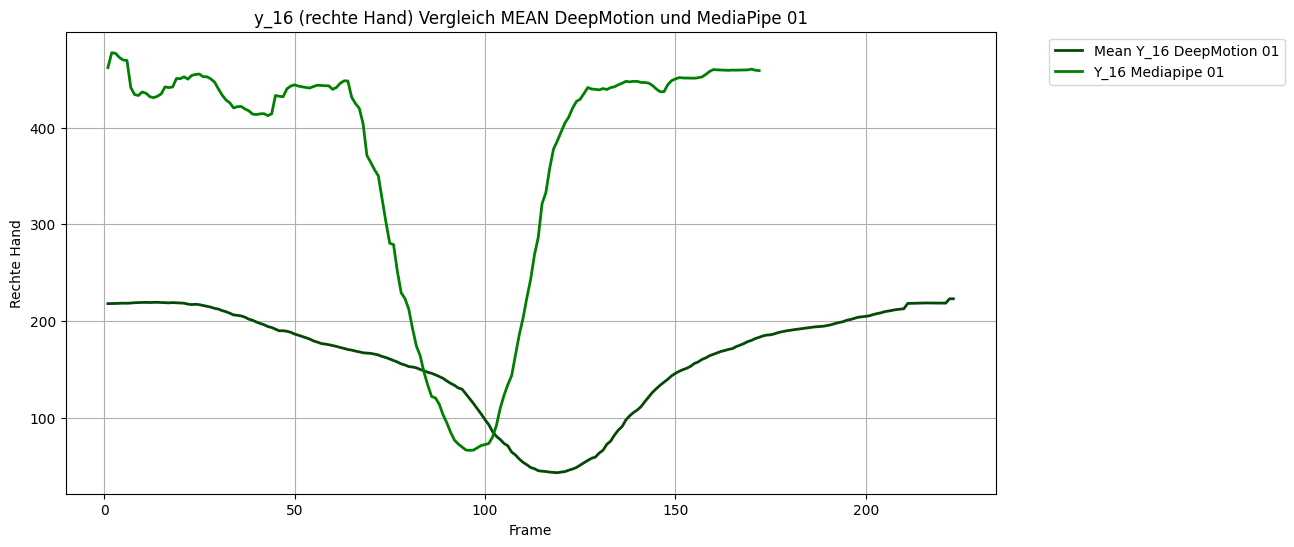

In [615]:
plt.figure(figsize=(12, 6))

plt.plot(mean_values_01.index, mean_values_01["y_16"], color='#054907', linestyle='-', linewidth=2, label='Mean Y_16 DeepMotion 01')
plt.plot(df_MediaP1["frame"], df_MediaP1["y_16"], color='green', linestyle='-', linewidth=2, label='Y_16 Mediapipe 01')

plt.title("y_16 (rechte Hand) Vergleich MEAN DeepMotion und MediaPipe 01")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [616]:
df_deepM01.head(5)

compensation  frame                                               path   
0             1      1  /Users/salomekoller/Library/CloudStorage/OneDr...  \
1             1      2  /Users/salomekoller/Library/CloudStorage/OneDr...   
2             1      3  /Users/salomekoller/Library/CloudStorage/OneDr...   
3             1      4  /Users/salomekoller/Library/CloudStorage/OneDr...   
4             1      5  /Users/salomekoller/Library/CloudStorage/OneDr...   

     x_0       x_1       x_2       x_3       x_4       x_5       x_6  ...   
0  0.000 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957  ...  \
1  1.909 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957  ...   
2  2.832 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957  ...   
3  3.748 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957  ...   
4  5.316 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957 -1007.957  ...   

        z_23       z_24      z_25      z_26       z_27       z_28      z_29   
0 -54.232452 -55.732347 -86.36791 -73.35297 -140.74894 -141.03328 -48.49379  \
1 -55.343797 -56.752106 -86.88588 -74.65325 -140.99239 -141.31013 -48.49379   
2 -55.947689 -57.295671 -87.15947 -75.24743 -140.94134 -141.37022 -48.49379   
3 -56.572451 -57.857934 -87.47403 -75.87163 -140.93407 -141.53690 -48.49379   
4 -57.970961 -59.166960 -88.48003 -77.44732 -141.46560 -142.56488 -48.49379   

       z_30      z_31      z_32  
0 -48.49379 -95.50346 -95.37153  
1 -48.49379 -95.63772 -95.59663  
2 -48.49379 -95.49199 -95.61985  
3 -48.49379 -95.39195 -95.76678  
4 -48.49379 -95.79207 -96.77919  

[5 rows x 102 columns]

#### 6.1.1 Euclidean Distances

In [617]:
# Definition von Kolonnen
columns = ['frame', 'x_0', 'y_0', 'z_0', 'x_11', 'y_11', 'z_11',
           'x_12', 'y_12', 'z_12', 'x_13', 'y_13', 'z_13', 'x_14', 'y_14', 'z_14', 'x_15', 'y_15', 'z_15',
           'x_16', 'y_16', 'z_16', 'x_17', 'y_17', 'z_17', 'x_18', 'y_18', 'z_18', 'x_19', 'y_19', 'z_19',
           'x_20', 'y_20', 'z_20', 'x_21', 'y_21', 'z_21', 'x_22', 'y_22', 'z_22', 'x_23', 'y_23', 'z_23',
           'x_24', 'y_24', 'z_24', 'x_25', 'y_25', 'z_25', 'x_26', 'y_26', 'z_26', 'x_27', 'y_27', 'z_27',
           'x_28', 'y_28', 'z_28', 'x_31', 'y_31', 'z_31', 'x_32', 'y_32', 'z_32']

# Kalkulieren von euclidean Distance
euclidean_distances_01 = {}

for frame in df_MediaP1["frame"]:
    euclidean_distances_01[frame] = []
    for col in columns[1:]:
        point_1 = (frame, mean_values_01[col].loc[frame])
        point_2 = (frame, df_MediaP1[col][df_MediaP1['frame'] == frame].values[0])
        euclidean_distance_01 = distance.euclidean(point_1, point_2)
        euclidean_distances_01[frame].append(euclidean_distance_01)

euclidean_df_01 = pd.DataFrame.from_dict(euclidean_distances_01, orient='index', columns=columns[1:])
euclidean_df_01.head(5)

x_0       y_0         z_0     x_11      y_11         z_11       x_12   
1  42.92380  16.61496  200.431752  69.3176  90.13566   758.638164  168.83520  \
2  44.95106  15.95476  263.983176  69.9716  89.87085   831.607521  171.16664   
3  47.12266  15.15391  347.277852  70.6990  91.24217   862.063893  173.41177   
4  49.02955  14.35974  555.240142  69.6152  91.58547  1001.308958  175.43172   
5  51.61540  14.09434  658.537104  70.5362  92.12765  1103.323308  177.55982   

       y_12         z_12     x_13  ...        z_27       x_28       y_28   
1  74.98150   659.808978  10.8751  ...  410.550930  140.81896  285.66887  \
2  76.69971   806.748098  24.7191  ...  524.462780  143.35470  163.73097   
3  78.77599   878.335758  29.4000  ...  492.755260  148.24251  138.85617   
4  80.24593  1026.844498  30.8039  ...  684.222126  147.70005  104.16461   
5  81.06427  1107.191584  28.8831  ...  365.779952  144.68048   92.63177   

          z_28     x_31       y_31        z_31       x_32       y_32   
1   557.936898  40.2032  360.93982  127.062284  133.59999  337.01767  \
2   755.557618   0.2076  295.62517  210.271596  142.86184  199.88443   
3   840.397456  21.9266  202.24192  179.669690  147.59591  152.12417   
4  1560.973172   7.3896  161.01887  365.837102  145.99192   89.07367   
5   324.185228  34.6771  170.08901   72.359426  139.14976  122.45942   

          z_32  
1   339.573678  
2   434.117598  
3   495.328962  
4  1290.059868  
5     6.418400  

[5 rows x 63 columns]

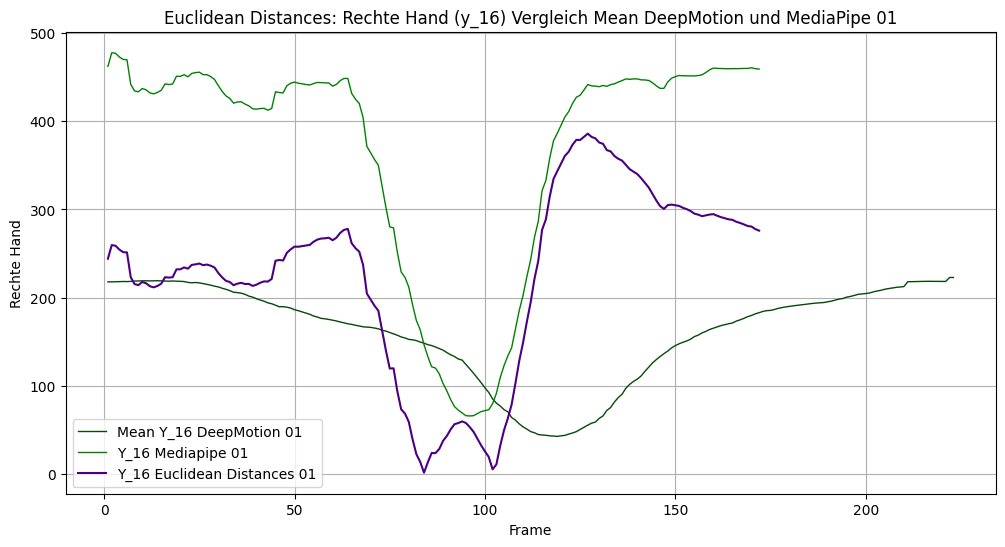

In [618]:
plt.figure(figsize=(12, 6))

plt.plot(mean_values_01.index, mean_values_01["y_16"], color='#054907', linestyle='-', linewidth=1, label='Mean Y_16 DeepMotion 01')
plt.plot(df_MediaP1["frame"], df_MediaP1["y_16"], color='green', linestyle='-', linewidth=1, label='Y_16 Mediapipe 01')

plt.plot(euclidean_df_01.index, euclidean_df_01["y_16"], color='indigo', linestyle='-', linewidth=1.5, label='Y_16 Euclidean Distances 01')


plt.title("Euclidean Distances: Rechte Hand (y_16) Vergleich Mean DeepMotion und MediaPipe 01")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend(loc='best')
plt.show()

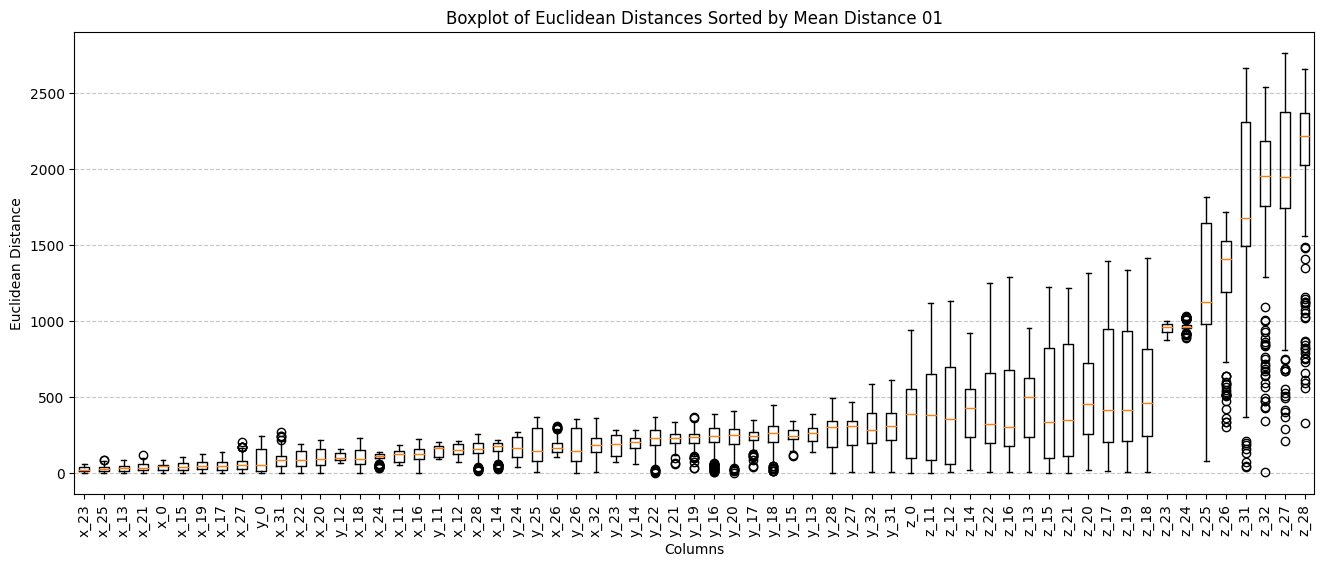

In [619]:
mean_distances = euclidean_df_01.mean()
sorted_df = euclidean_df_01[mean_distances.sort_values().index]

plt.figure(figsize=(16, 6))
plt.boxplot(sorted_df.values)
plt.xticks(range(1, len(sorted_df.columns) + 1), sorted_df.columns, rotation=90)
plt.title('Boxplot of Euclidean Distances Sorted by Mean Distance 01')
plt.xlabel('Columns')
plt.ylabel('Euclidean Distance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 6.1.1.1 Ohne Z Werte

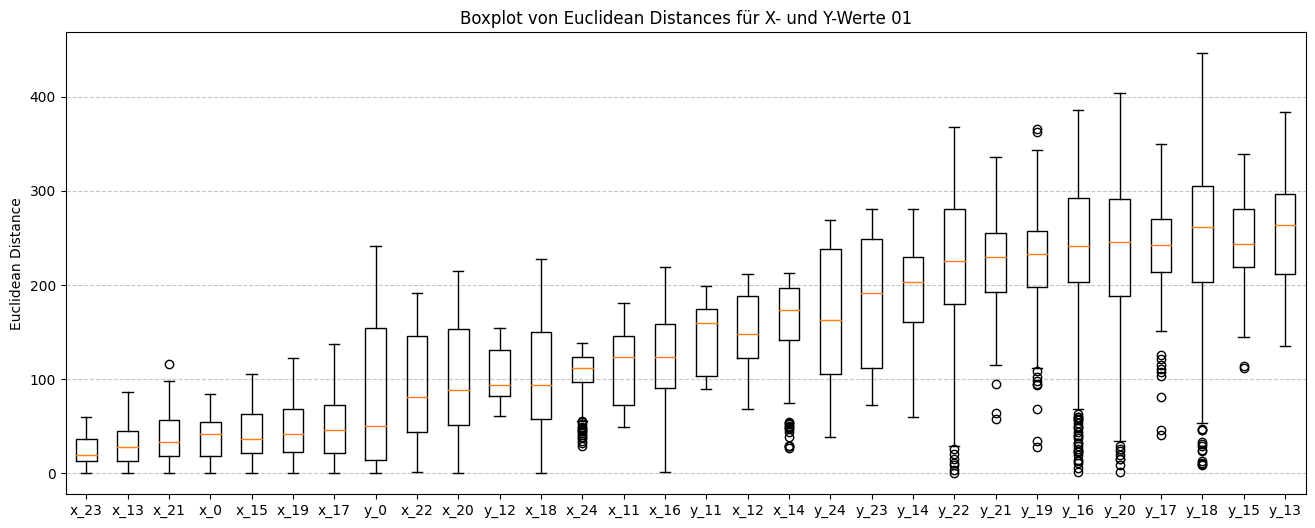

In [620]:
# Definition von Kolonnen
selected_columns = ['x_0', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 
                    'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'y_0', 
                    'y_11', 'y_12', 'y_13', 'y_14', 'y_15', 'y_16', 'y_17', 
                    'y_18', 'y_19', 'y_20', 'y_21', 'y_22', 'y_23', 'y_24']

mean_distances = euclidean_df_01[selected_columns].mean()
sorted_df = euclidean_df_01[mean_distances.sort_values().index]

plt.figure(figsize=(16, 6))
plt.boxplot(sorted_df.values)
plt.xticks(range(1, len(sorted_df.columns) + 1), sorted_df.columns)
plt.title('Boxplot von Euclidean Distances für X- und Y-Werte 01')
plt.ylabel('Euclidean Distance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 6.2 Kompensiert 02

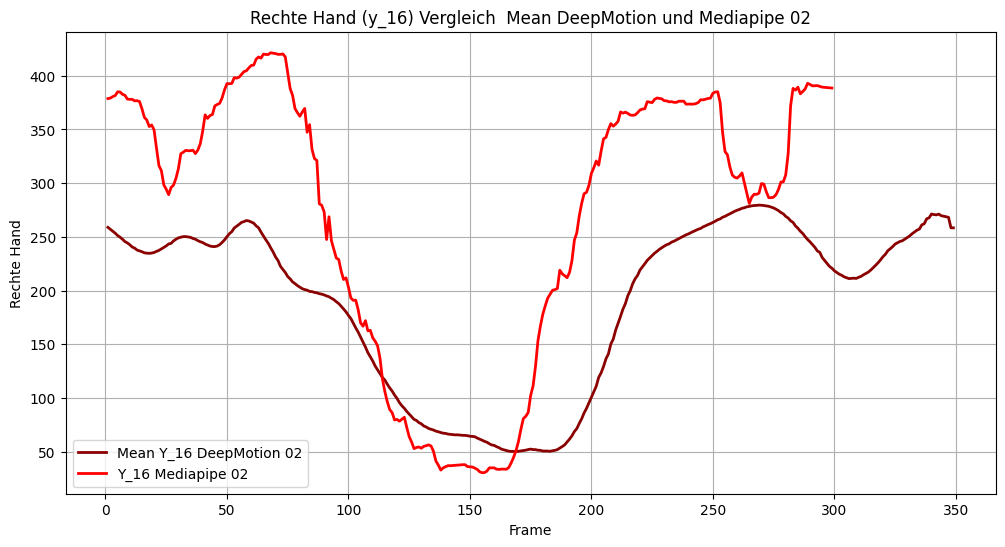

In [621]:
plt.figure(figsize=(12, 6))

plt.plot(mean_values_02.index, mean_values_02["y_16"], color='darkred', linestyle='-', linewidth=2, label='Mean Y_16 DeepMotion 02')
plt.plot(df_MediaP2["frame"], df_MediaP2["y_16"], color='red', linestyle='-', linewidth=2, label='Y_16 Mediapipe 02')

plt.title("Rechte Hand (y_16) Vergleich  Mean DeepMotion und Mediapipe 02")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend( loc='best')
plt.show()

### 6.2.1 Euclidean Distances

In [622]:
# Definition von Kolonnen
columns = ['frame', 'x_0', 'y_0', 'z_0', 'x_11', 'y_11', 'z_11',
           'x_12', 'y_12', 'z_12', 'x_13', 'y_13', 'z_13', 'x_14', 'y_14', 'z_14', 'x_15', 'y_15', 'z_15',
           'x_16', 'y_16', 'z_16', 'x_17', 'y_17', 'z_17', 'x_18', 'y_18', 'z_18', 'x_19', 'y_19', 'z_19',
           'x_20', 'y_20', 'z_20', 'x_21', 'y_21', 'z_21', 'x_22', 'y_22', 'z_22', 'x_23', 'y_23', 'z_23',
           'x_24', 'y_24', 'z_24', 'x_25', 'y_25', 'z_25', 'x_26', 'y_26', 'z_26', 'x_27', 'y_27', 'z_27',
           'x_28', 'y_28', 'z_28', 'x_31', 'y_31', 'z_31', 'x_32', 'y_32', 'z_32']

# Kalkulieren von euclidean Distance
euclidean_distances_02 = {}

for frame in df_MediaP2["frame"]:
    euclidean_distances_02[frame] = []
    for col in columns[1:]:
        point_1 = (frame, mean_values_02[col].loc[frame])
        point_2 = (frame, df_MediaP2[col][df_MediaP2['frame'] == frame].values[0])
        euclidean_distance_02 = distance.euclidean(point_1, point_2)
        euclidean_distances_02[frame].append(euclidean_distance_02)

euclidean_df_02 = pd.DataFrame.from_dict(euclidean_distances_02, orient='index', columns=columns[1:])
euclidean_df_02.head(5)

x_0      y_0         z_0       x_11      y_11        z_11      x_12   
1  80.50884  8.62712  102.583294  204.19991  75.73850  612.477154  33.43345  \
2  77.94733  7.08524   98.897278  202.00413  75.67390  621.639808  34.80006   
3  75.41739  4.93818   60.819862  199.83341  74.17957  609.463960  36.16155   
4  74.19701  4.39192   41.274056  197.32713  72.01682  591.316945  37.25993   
5  72.76259  2.55040    4.149380  195.28057  69.82888  569.920596  37.51685   

       y_12        z_12       x_13  ...        z_27      x_28       y_28   
1  38.33725  603.094474  150.98677  ...  467.131492  62.47735  126.82504  \
2  39.15704  605.273147  153.93395  ...  429.987844  70.76138  146.65892   
3  39.78898  590.131785  154.25215  ...  422.519454  74.54285  153.74438   
4  40.15608  572.235943  151.83201  ...  422.745214  75.23707  160.14372   
5  40.32108  549.975651  150.62297  ...  424.255892  75.12673  158.61992   

         z_28      x_31       y_31        z_31      x_32       y_32   
1  413.357570  52.07991  168.47666  266.791801  53.85387  216.86268  \
2  365.403114  48.45663  162.20510  210.542933  65.33933  216.29908   
3  362.500270  45.97739  159.59616  200.309537  70.10561  216.14918   
4  343.524672  45.84213  157.39922  197.384421  69.77957  217.45988   
5  355.788026  45.59415  152.43198  208.575268  69.33975  216.81418   

         z_32  
1  151.802428  
2   84.407734  
3   82.846711  
4   49.359925  
5   72.823118  

[5 rows x 63 columns]

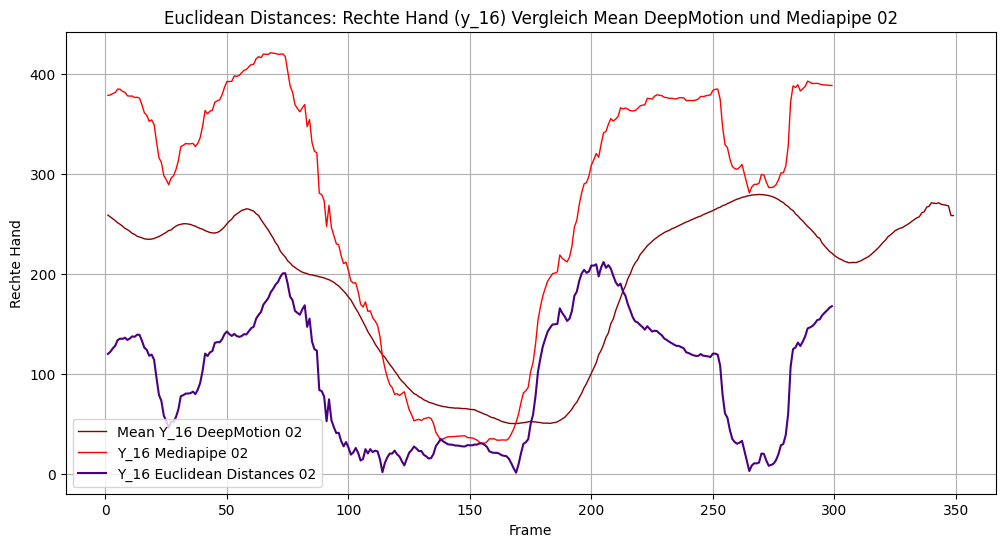

In [623]:
plt.figure(figsize=(12, 6))

plt.plot(mean_values_02.index, mean_values_02["y_16"], color='darkred', linestyle='-', linewidth=1, label='Mean Y_16 DeepMotion 02')
plt.plot(df_MediaP2["frame"], df_MediaP2["y_16"], color='red', linestyle='-', linewidth=1, label='Y_16 Mediapipe 02')

plt.plot(euclidean_df_02.index, euclidean_df_02["y_16"], color='indigo', linestyle='-', linewidth=1.5, label='Y_16 Euclidean Distances 02')

plt.title("Euclidean Distances: Rechte Hand (y_16) Vergleich Mean DeepMotion und Mediapipe 02")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend( loc='best')
plt.show()

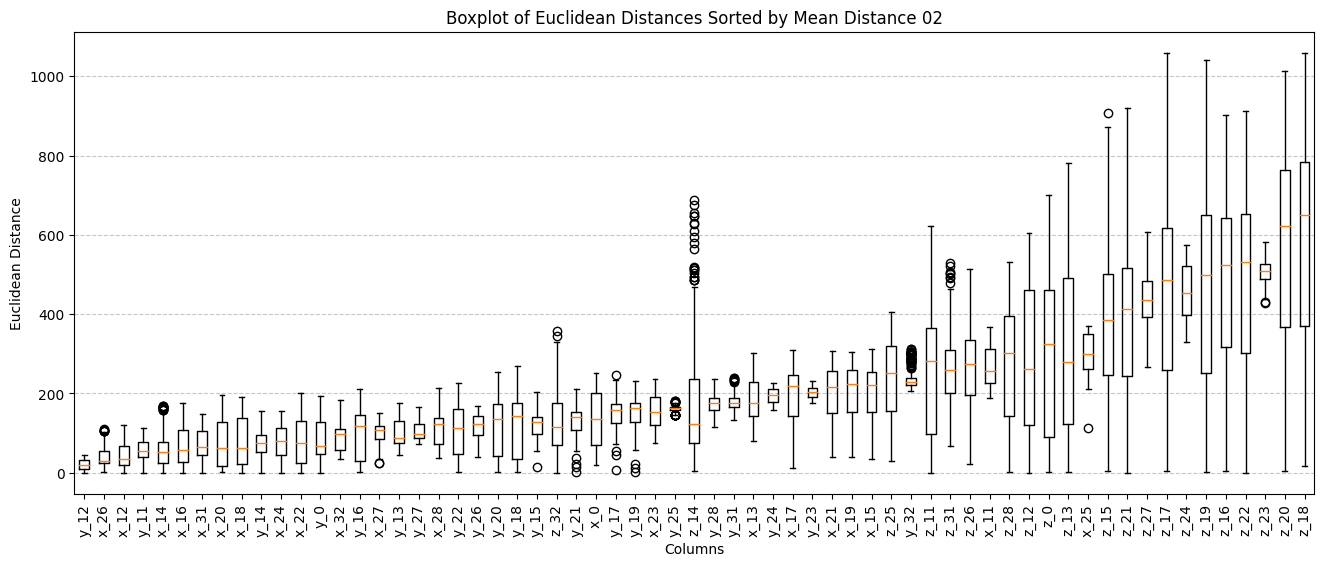

In [624]:
mean_distances = euclidean_df_02.mean()
sorted_df = euclidean_df_02[mean_distances.sort_values().index]

plt.figure(figsize=(16, 6))
plt.boxplot(sorted_df.values)
plt.xticks(range(1, len(sorted_df.columns) + 1), sorted_df.columns, rotation=90)
plt.title('Boxplot of Euclidean Distances Sorted by Mean Distance 02')
plt.xlabel('Columns')
plt.ylabel('Euclidean Distance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 6.2.1.1 Ohne Z Werte

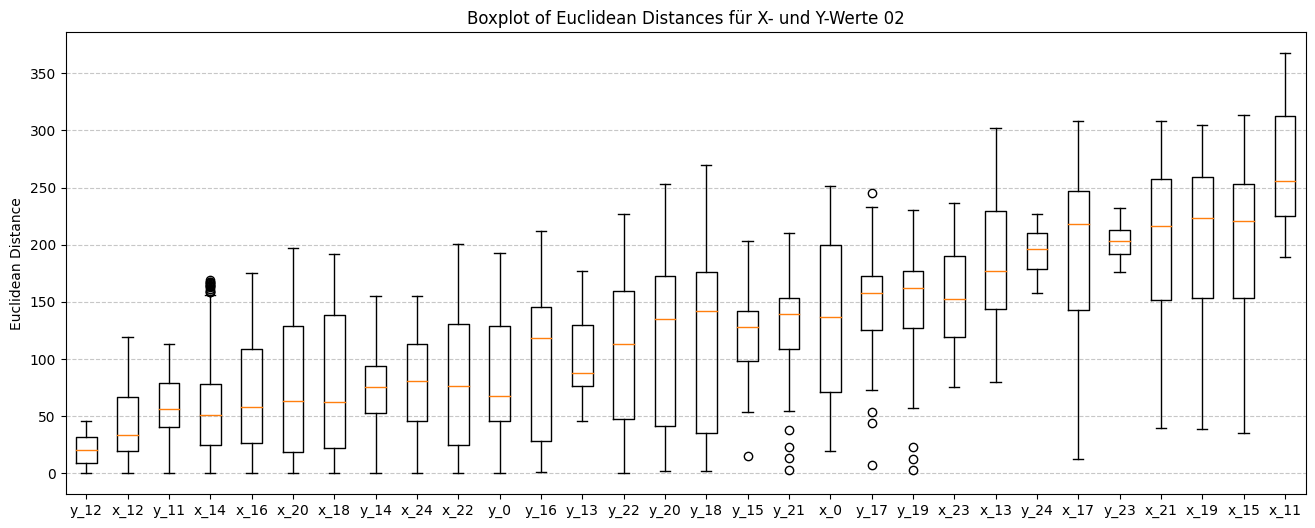

In [625]:
# Definition von Kolonnen
selected_columns = ['x_0', 'x_11', 'x_12', 'x_13', 
                    'x_14', 'x_15', 'x_16', 'x_17', 
                    'x_18', 'x_19', 'x_20', 'x_21', 
                    'x_22', 'x_23', 'x_24', 'y_0', 
                    'y_11', 'y_12', 'y_13', 
                    'y_14', 'y_15', 'y_16', 'y_17', 
                    'y_18', 'y_19', 'y_20', 'y_21', 
                    'y_22', 'y_23', 'y_24']

mean_distances = euclidean_df_02[selected_columns].mean()
sorted_df = euclidean_df_02[mean_distances.sort_values().index]

plt.figure(figsize=(16, 6))
plt.boxplot(sorted_df.values)
plt.xticks(range(1, len(sorted_df.columns) + 1), sorted_df.columns)
plt.title('Boxplot of Euclidean Distances für X- und Y-Werte 02')
plt.ylabel('Euclidean Distance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 6.3 Nicht Kompensiert 03

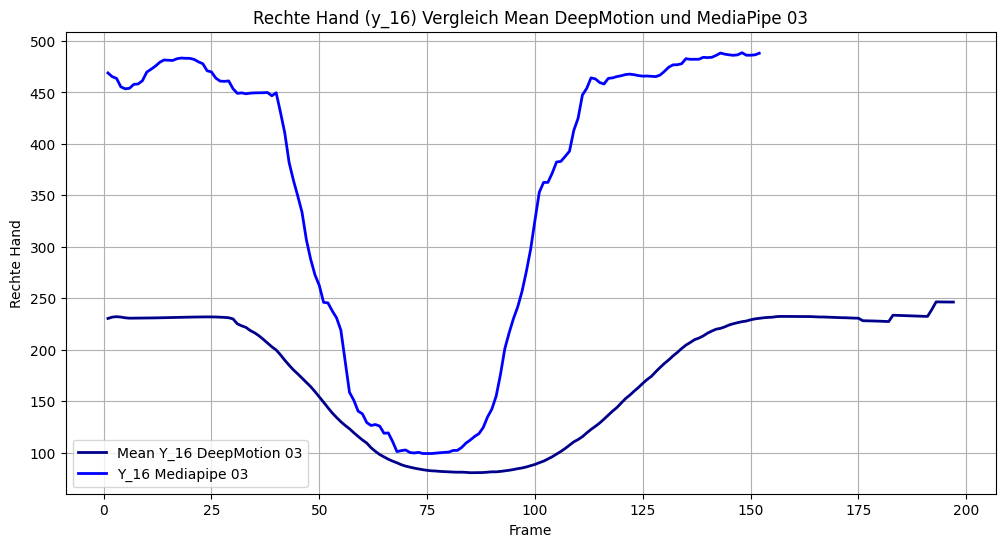

In [626]:
plt.figure(figsize=(12, 6))

plt.plot(mean_values_03.index, mean_values_03["y_16"], color='darkblue', linestyle='-', linewidth=2, label='Mean Y_16 DeepMotion 03')
plt.plot(df_MediaP3["frame"], df_MediaP3["y_16"], color='blue', linestyle='-', linewidth=2, label='Y_16 Mediapipe 03')

plt.title("Rechte Hand (y_16) Vergleich Mean DeepMotion und MediaPipe 03")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend(loc='best')
plt.show()

### 6.3.1 Euclidean Distances

In [627]:
# Definition von Kolonnen
columns = ['frame', 'x_0', 'y_0', 'z_0', 'x_11', 'y_11', 'z_11',
           'x_12', 'y_12', 'z_12', 'x_13', 'y_13', 'z_13', 'x_14', 'y_14', 'z_14', 'x_15', 'y_15', 'z_15',
           'x_16', 'y_16', 'z_16', 'x_17', 'y_17', 'z_17', 'x_18', 'y_18', 'z_18', 'x_19', 'y_19', 'z_19',
           'x_20', 'y_20', 'z_20', 'x_21', 'y_21', 'z_21', 'x_22', 'y_22', 'z_22', 'x_23', 'y_23', 'z_23',
           'x_24', 'y_24', 'z_24', 'x_25', 'y_25', 'z_25', 'x_26', 'y_26', 'z_26', 'x_27', 'y_27', 'z_27',
           'x_28', 'y_28', 'z_28', 'x_31', 'y_31', 'z_31', 'x_32', 'y_32', 'z_32']

# Kalkulieren von euclidean Distance
euclidean_distances_03 = {}

for frame in df_MediaP3["frame"]:
    euclidean_distances_03[frame] = []
    for col in columns[1:]:
        point_1 = (frame, mean_values_03[col].loc[frame])
        point_2 = (frame, df_MediaP3[col][df_MediaP3['frame'] == frame].values[0])
        euclidean_distance_03 = distance.euclidean(point_1, point_2)
        euclidean_distances_03[frame].append(euclidean_distance_03)

euclidean_df_03 = pd.DataFrame.from_dict(euclidean_distances_03, orient='index', columns=columns[1:])
euclidean_df_03.head(5)

x_0       y_0         z_0     x_11      y_11        z_11       x_12   
1  65.99356  18.27286  171.467506  49.6439  99.93474  668.763334  205.30202  \
2  67.48476  19.79484  130.008146  48.9014  95.24961  431.186842  206.08323   
3  68.77944  20.10476  121.484736  48.5285  93.40679  434.953544  207.17242   
4  70.54364  19.92736    2.222716  49.3687  93.34960  490.740326  208.43588   
5  71.39090  19.31311   24.813634  49.5948  93.57797  519.740428  209.44843   

       y_12        z_12    x_13  ...         z_27       x_28       y_28   
1  74.48721  688.282391  0.7459  ...   413.052336  225.08979    8.99114  \
2  75.83324  440.554680  2.6915  ...  1435.074708  205.41174  192.81236   
3  78.70648  481.038302  4.2624  ...  1514.271030  202.19752  231.88596   
4  80.55566  555.391135  5.0053  ...  1645.335350  192.36276  259.18446   
5  83.20356  578.571426  6.1327  ...  1517.501582  189.90474  261.74046   

          z_28      x_31       y_31         z_31       x_32       y_32   
1  1231.108256   99.1440   27.38124   104.787014  248.68692    8.48936  \
2  1900.078300   79.3313  236.46426  1119.853360  219.20268  227.20806   
3  1928.342220   81.6821  289.53926  1210.362002  208.15234  268.37936   
4  1888.054050  114.2689  311.15276  1365.978848  185.98669  298.26186   
5  1807.583922  112.8796  313.48996  1245.937974  183.33859  300.14266   

          z_32  
1   973.747530  
2  1584.072346  
3  1617.334324  
4  1590.564258  
5  1524.639030  

[5 rows x 63 columns]

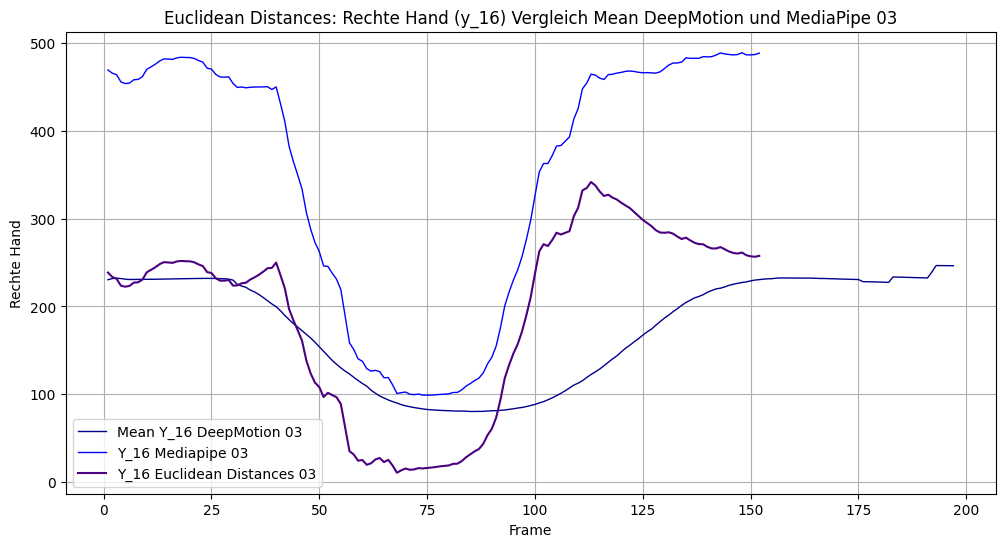

In [628]:
plt.figure(figsize=(12, 6))

plt.plot(mean_values_03.index, mean_values_03["y_16"], color='darkblue', linestyle='-', linewidth=1, label='Mean Y_16 DeepMotion 03')
plt.plot(df_MediaP3["frame"], df_MediaP3["y_16"], color='blue', linestyle='-', linewidth=1, label='Y_16 Mediapipe 03')

plt.plot(euclidean_df_03.index, euclidean_df_03["y_16"], color='indigo', linestyle='-', linewidth=1.5, label='Y_16 Euclidean Distances 03')

plt.title("Euclidean Distances: Rechte Hand (y_16) Vergleich Mean DeepMotion und MediaPipe 03")
plt.xlabel("Frame")
plt.ylabel("Rechte Hand")
plt.grid(True)
plt.legend(loc='best')
plt.show()

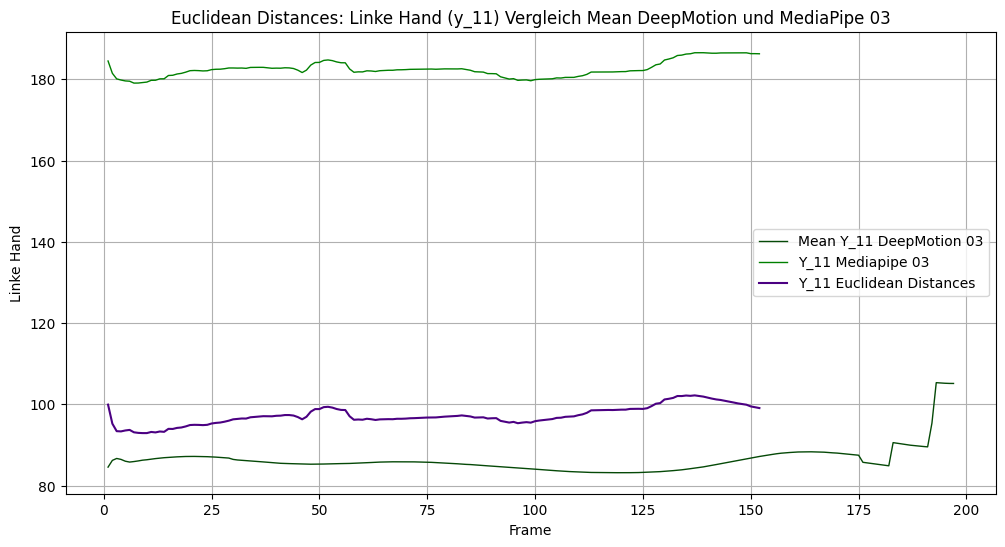

In [629]:
plt.figure(figsize=(12, 6))

plt.plot(mean_values_03.index, mean_values_03["y_11"], color='#054907', linestyle='-', linewidth=1, label='Mean Y_11 DeepMotion 03')
plt.plot(df_MediaP3["frame"], df_MediaP3["y_11"], color='green', linestyle='-', linewidth=1, label='Y_11 Mediapipe 03')

plt.plot(euclidean_df_03.index, euclidean_df_03["y_11"], color='indigo', linestyle='-', linewidth=1.5, label='Y_11 Euclidean Distances')

plt.title("Euclidean Distances: Linke Hand (y_11) Vergleich Mean DeepMotion und MediaPipe 03")
plt.xlabel("Frame")
plt.ylabel("Linke Hand")
plt.grid(True)
plt.legend(loc='best')
plt.show()

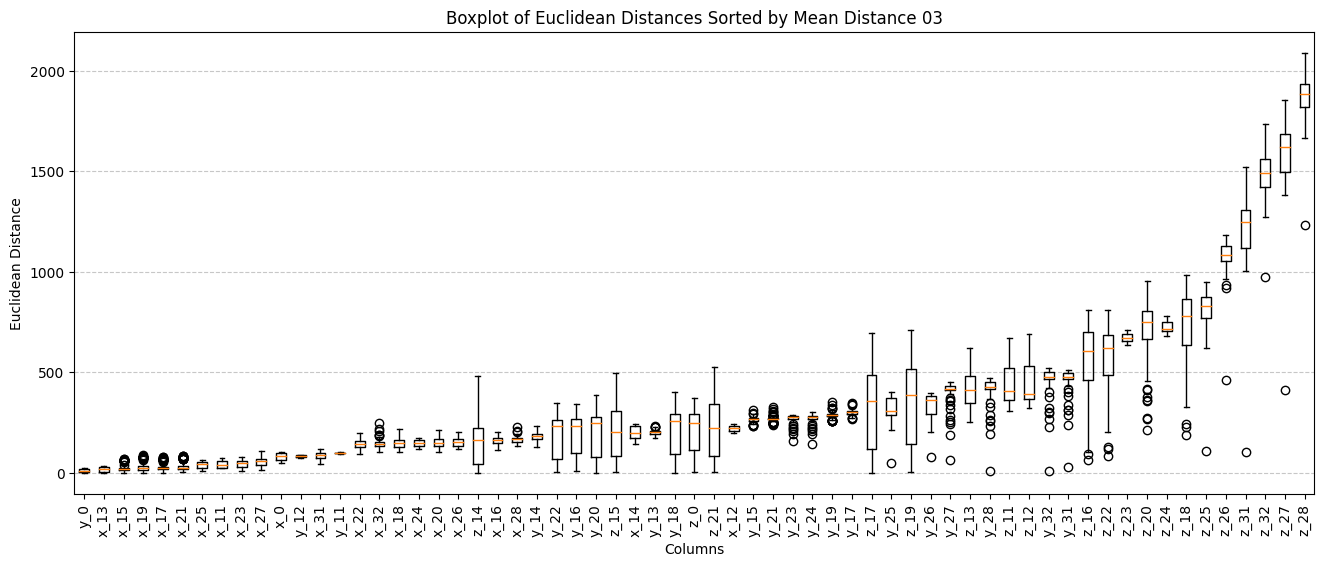

In [630]:
mean_distances = euclidean_df_03.mean()
sorted_df = euclidean_df_03[mean_distances.sort_values().index]

plt.figure(figsize=(16, 6))
plt.boxplot(sorted_df.values)
plt.xticks(range(1, len(sorted_df.columns) + 1), sorted_df.columns, rotation=90)
plt.title('Boxplot of Euclidean Distances Sorted by Mean Distance 03')
plt.xlabel('Columns')
plt.ylabel('Euclidean Distance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 6.3.1.1 Ohne Z Werte

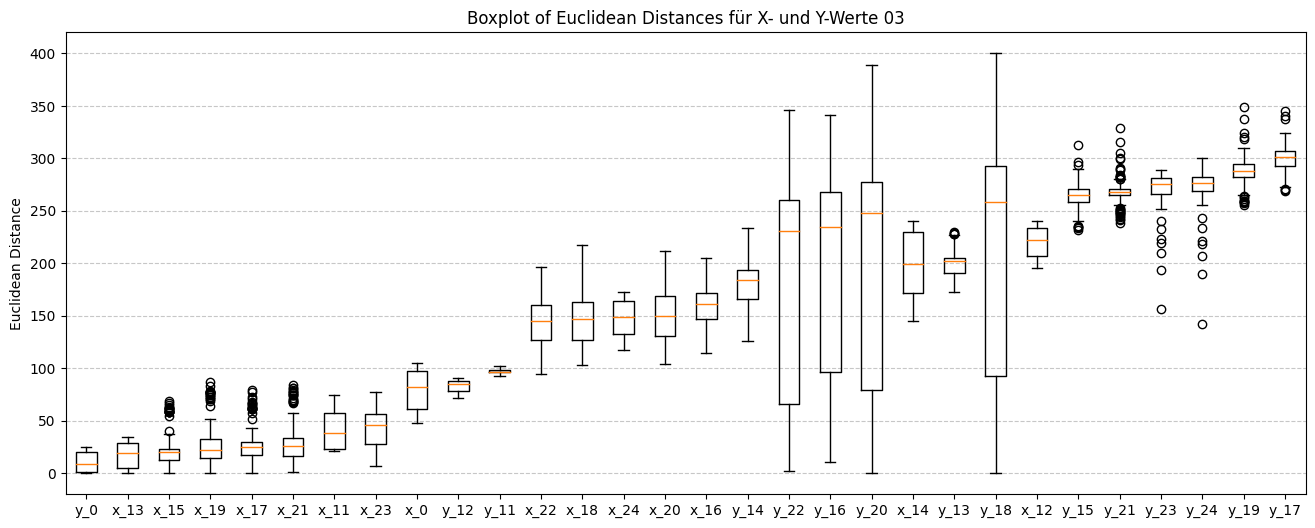

In [631]:
# Definition von Kolonnen
selected_columns = ['x_0', 'x_11', 'x_12', 'x_13', 
                    'x_14', 'x_15', 'x_16', 'x_17', 
                    'x_18', 'x_19', 'x_20', 'x_21', 
                    'x_22', 'x_23', 'x_24', 'y_0', 
                    'y_11', 'y_12', 'y_13', 
                    'y_14', 'y_15', 'y_16', 'y_17', 
                    'y_18', 'y_19', 'y_20', 'y_21', 
                    'y_22', 'y_23', 'y_24']

mean_distances = euclidean_df_03[selected_columns].mean()
sorted_df = euclidean_df_03[mean_distances.sort_values().index]

plt.figure(figsize=(16, 6))
plt.boxplot(sorted_df.values)
plt.xticks(range(1, len(sorted_df.columns) + 1), sorted_df.columns)
plt.title('Boxplot of Euclidean Distances für X- und Y-Werte 03')
plt.ylabel('Euclidean Distance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Erkenntnisse

- Trinkarm ist viel ungenauer, als der ruhende Arm
- Videoaufnahmen: Arm ist wegen Shirt nicht ersichtlich
- Videoaufnahmen: Beine in Sitzposition können irritieren durch Tisch
- Z Werte können nicht verwendet werden für Analyse Performance
- Nicht Kompensierte Bewegung hat viel kleinere Ranges von Differenzen weil Bewegung sehr klar ist

## 7. Vergleich ganzer Oberkörper

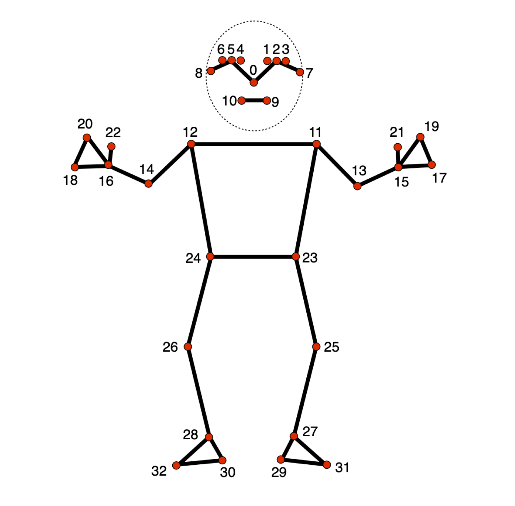

In [632]:
img = plt.imread('Pictures/landmark.png')
im = OffsetImage(img, zoom=0.2) 
ab = AnnotationBbox(im, (0.5, 0.5), frameon=False)
plt.gca().add_artist(ab)
plt.axis('off')
plt.show()

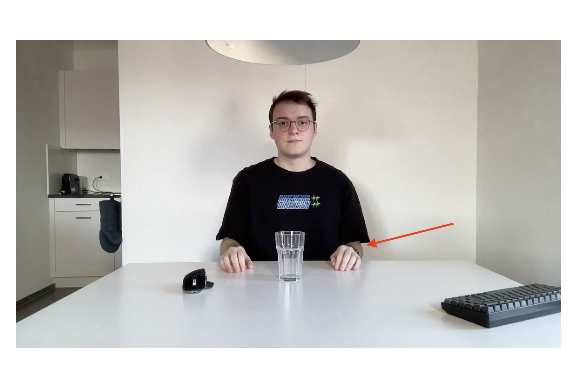

In [633]:
img = plt.imread('Pictures/ausgangsposition.jpg')
im = OffsetImage(img, zoom=0.2)
ab = AnnotationBbox(im, (0.5, 0.5), frameon=False)
plt.gca().add_artist(ab)
plt.axis('off')
plt.show()

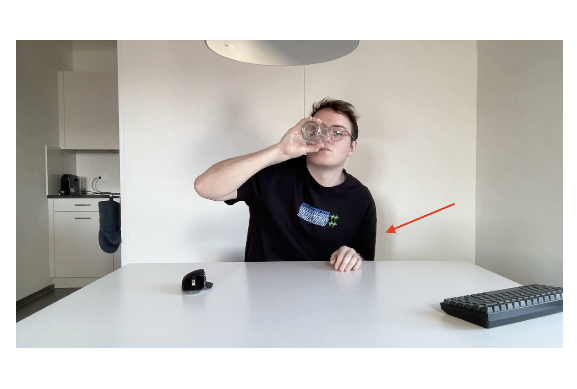

In [634]:
img = plt.imread('Pictures/bewegung.jpg')
im = OffsetImage(img, zoom=0.2)
ab = AnnotationBbox(im, (0.5, 0.5), frameon=False)
plt.gca().add_artist(ab)

plt.axis('off')
plt.show()

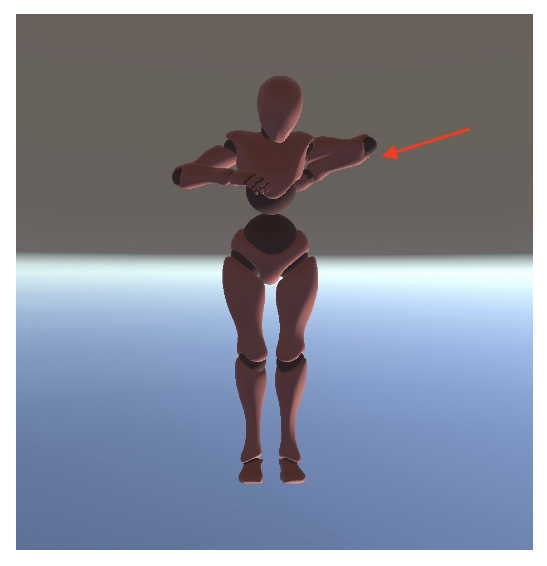

In [635]:
img = plt.imread('Pictures/komp_1.jpg')
im = OffsetImage(img, zoom=0.4)
ab = AnnotationBbox(im, (0.5, 0.5), frameon=False)
plt.gca().add_artist(ab)

plt.axis('off')
plt.show()

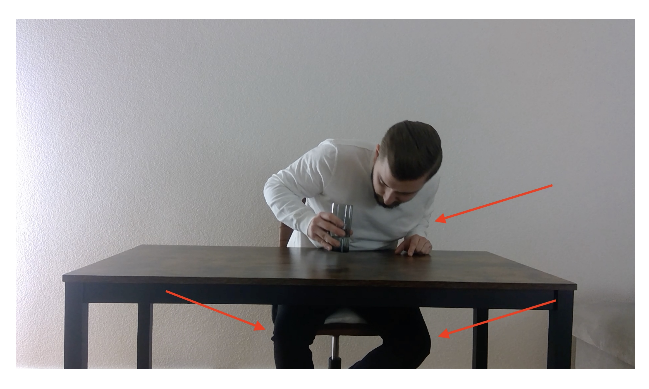

In [636]:
img = plt.imread('Pictures/komp2.jpg')
im = OffsetImage(img, zoom=0.2)
ab = AnnotationBbox(im, (0.5, 0.5), frameon=False)
plt.gca().add_artist(ab)

plt.axis('off')
plt.show()

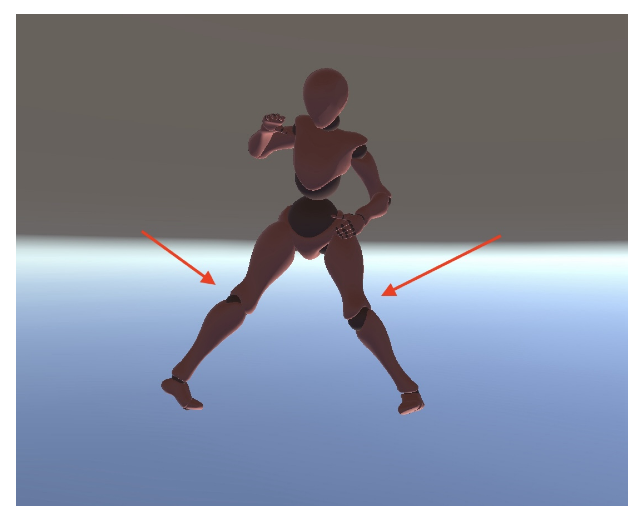

In [637]:
img = plt.imread('Pictures/x_2.jpg')
im = OffsetImage(img, zoom=0.4)
ab = AnnotationBbox(im, (0.5, 0.5), frameon=False)
plt.gca().add_artist(ab)

plt.axis('off')
plt.show()

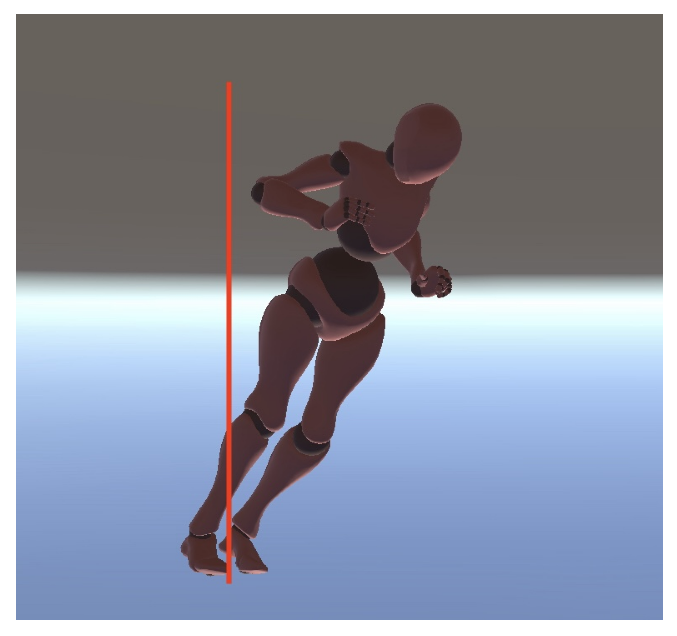

In [638]:
img = plt.imread('Pictures/x_3.jpg')
im = OffsetImage(img, zoom=0.6)
ab = AnnotationBbox(im, (0.5, 0.5), frameon=False)
plt.gca().add_artist(ab)

plt.axis('off')
plt.show()

## 8. Difference in Mean Upper Body

- Jeglich die Oberarm Keypoints werden verglichen

### 8.1 Kompensation 01

In [639]:
selected_columns = ['x_0', 'y_0', 'z_0', 'x_11', 'y_11', 'z_11',
                    'x_12', 'y_12', 'z_12', 'x_13', 'y_13', 'z_13', 
                    'x_14', 'y_14', 'z_14', 'x_15', 'y_15', 'z_15',
                    'x_16', 'y_16', 'z_16', 'x_17', 'y_17', 'z_17', 
                    'x_18', 'y_18', 'z_18', 'x_19', 'y_19', 'z_19',
                    'x_20', 'y_20', 'z_20', 'x_21', 'y_21', 'z_21', 
                    'x_22', 'y_22', 'z_22', 'x_23', 'y_23', 'z_23',
                    'x_24', 'y_24', 'z_24']

difference_in_mean_upper_body_01 = df_MediaP1[selected_columns].mean() - mean_values_01[selected_columns].mean()
print(f"Mean Value in DeepMotion 01: {difference_in_mean_upper_body_01}")

Mean Value in DeepMotion 01: x_0      -3.319083
y_0      73.683774
z_0    -210.642338
x_11    116.795024
y_11    146.385612
z_11    374.395101
x_12   -149.673985
y_12    104.762081
z_12    374.873850
x_13     11.958495
y_13    257.475238
z_13    353.311798
x_14   -162.232370
y_14    183.706348
z_14    133.704332
x_15     21.795657
y_15    245.967297
z_15    -91.969699
x_16   -113.446733
y_16    205.357660
z_16   -389.343679
x_17     16.749902
y_17    238.363306
z_17   -211.062132
x_18    -94.916984
y_18    212.191708
z_18   -524.594197
x_19     23.633374
y_19    226.420394
z_19   -202.265748
x_20    -87.188510
y_20    200.584724
z_20   -479.274081
x_21     11.851888
y_21    223.093311
z_21    -99.649882
x_22    -76.151072
y_22    188.579113
z_22   -382.626055
x_23    -19.884797
y_23    183.582298
z_23    957.603535
x_24   -105.803264
y_24    164.761015
z_24    970.039118
dtype: float64


In [640]:
selected_columns_X = ['x_0', 'x_11', 'x_12', 'x_13', 
                    'x_14', 'x_15', 'x_16', 'x_17', 
                    'x_18', 'x_19', 'x_20', 'x_21', 
                    'x_22', 'x_23', 'x_24']

selected_columns_Y = ['y_0', 'y_11', 'y_12', 'y_13', 
                    'y_14', 'y_15', 'y_16', 'y_17', 
                    'y_18', 'y_19', 'y_20', 'y_21', 
                    'y_22', 'y_23', 'y_24']

selected_columns_Z = ['z_0', 'z_11', 'z_12', 'z_13', 
                    'z_14', 'z_15', 'z_16', 'z_17', 
                    'z_18', 'z_19', 'z_20', 'z_21', 
                    'z_22', 'z_23', 'z_24']

difference_in_mean_upper_body_01_X = difference_in_mean_upper_body_01[selected_columns_X]
difference_in_mean_upper_body_01_Y = difference_in_mean_upper_body_01[selected_columns_Y]
difference_in_mean_upper_body_01_Z = difference_in_mean_upper_body_01[selected_columns_Z]

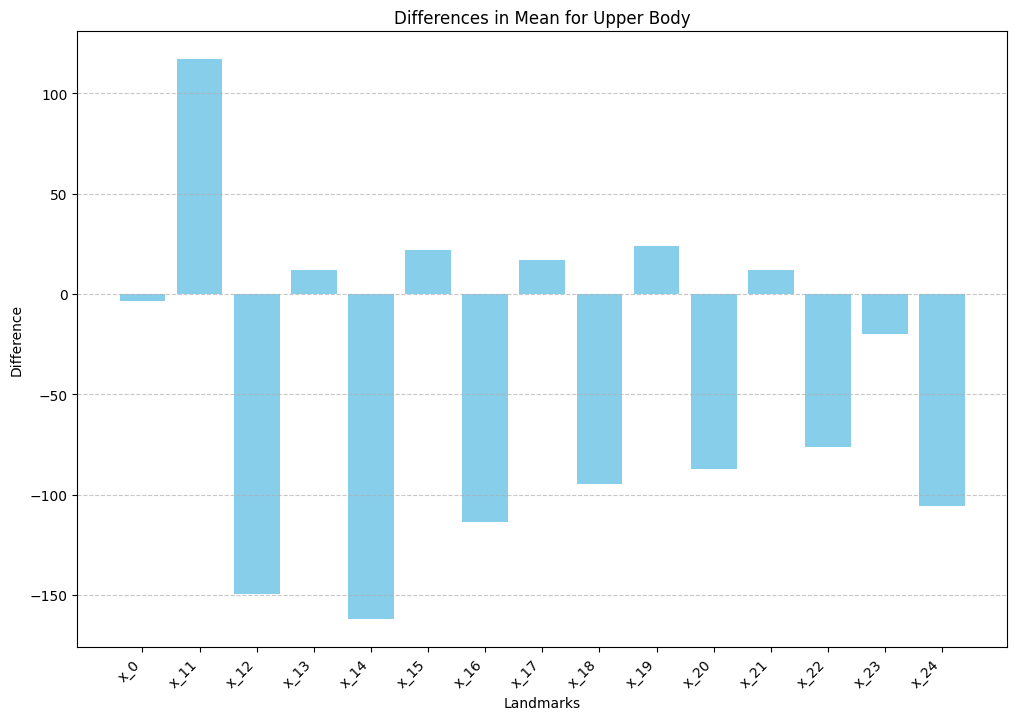

In [641]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(difference_in_mean_upper_body_01_X.index, difference_in_mean_upper_body_01_X, color='skyblue')
plt.title('Differences in Mean for Upper Body')
plt.xlabel('Landmarks')
plt.ylabel('Difference')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


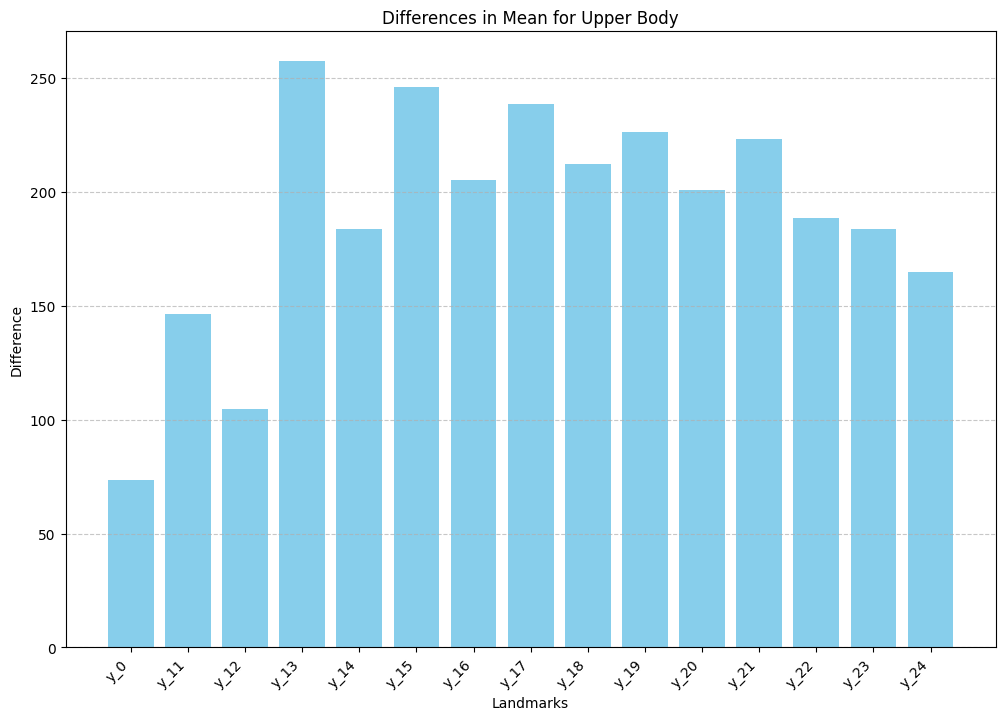

In [642]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(difference_in_mean_upper_body_01_Y.index, difference_in_mean_upper_body_01_Y, color='skyblue')
plt.title('Differences in Mean for Upper Body')
plt.xlabel('Landmarks')
plt.ylabel('Difference')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

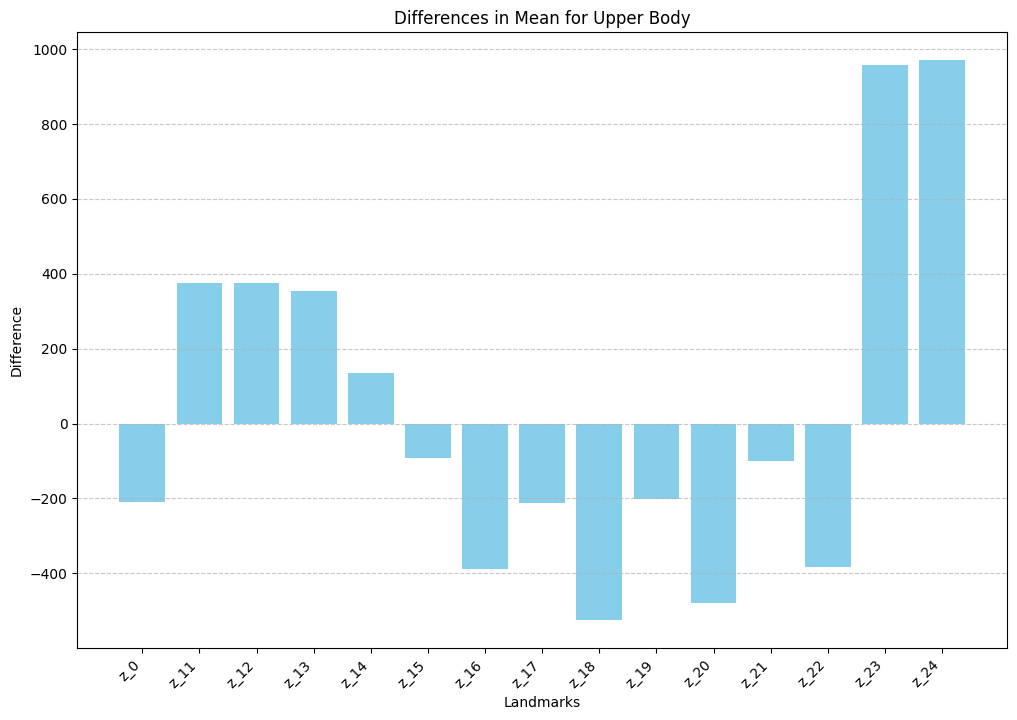

In [643]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(difference_in_mean_upper_body_01_Z.index, difference_in_mean_upper_body_01_Z, color='skyblue')
plt.title('Differences in Mean for Upper Body')
plt.xlabel('Landmarks')
plt.ylabel('Difference')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 8.2 Kompensation 02

In [644]:
difference_in_mean_upper_body_02 = df_MediaP2[selected_columns].mean() - mean_values_02[selected_columns].mean()
print(f"Mean Value in DeepMotion 02: {difference_in_mean_upper_body_02}")

Mean Value in DeepMotion 02: x_0     150.901215
y_0      45.595955
z_0    -227.528791
x_11    283.252751
y_11     61.692810
z_11    285.009399
x_12     46.207360
y_12     15.589027
z_12    262.641740
x_13    197.326623
y_13    102.834697
z_13    315.100115
x_14     65.072355
y_14     74.540943
z_14    132.690039
x_15    222.777897
y_15    126.753305
z_15   -184.942157
x_16     80.540867
y_16     79.985625
z_16   -418.256537
x_17    212.372087
y_17    155.749507
z_17   -296.386476
x_18     92.287134
y_18    103.080864
z_18   -534.293733
x_19    222.254899
y_19    158.058629
z_19   -341.451427
x_20     92.491910
y_20     99.587247
z_20   -536.114006
x_21    221.153078
y_21    136.507000
z_21   -220.009200
x_22     97.359988
y_22     83.443998
z_22   -434.171967
x_23    167.449638
y_23    204.225627
z_23    529.435083
x_24     91.554630
y_24    196.521203
z_24    480.946851
dtype: float64


In [645]:
difference_in_mean_upper_body_02_X = difference_in_mean_upper_body_02[selected_columns_X]
difference_in_mean_upper_body_02_Y = difference_in_mean_upper_body_02[selected_columns_Y]
difference_in_mean_upper_body_02_Z = difference_in_mean_upper_body_02[selected_columns_Z]

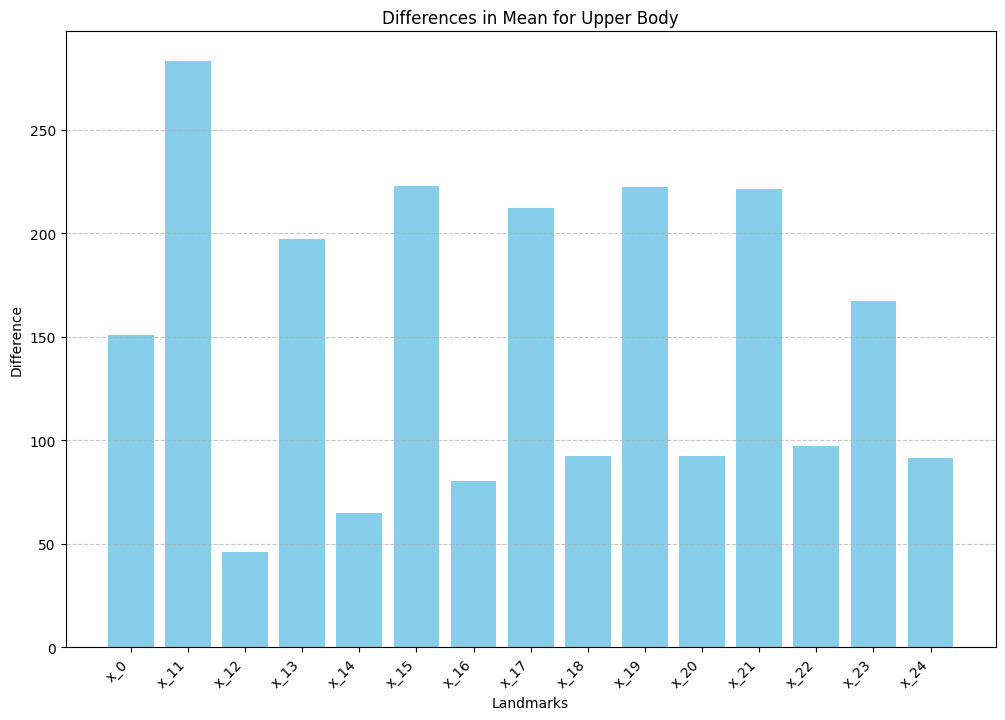

In [646]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(difference_in_mean_upper_body_02_X.index, difference_in_mean_upper_body_02_X, color='skyblue')
plt.title('Differences in Mean for Upper Body')
plt.xlabel('Landmarks')
plt.ylabel('Difference')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

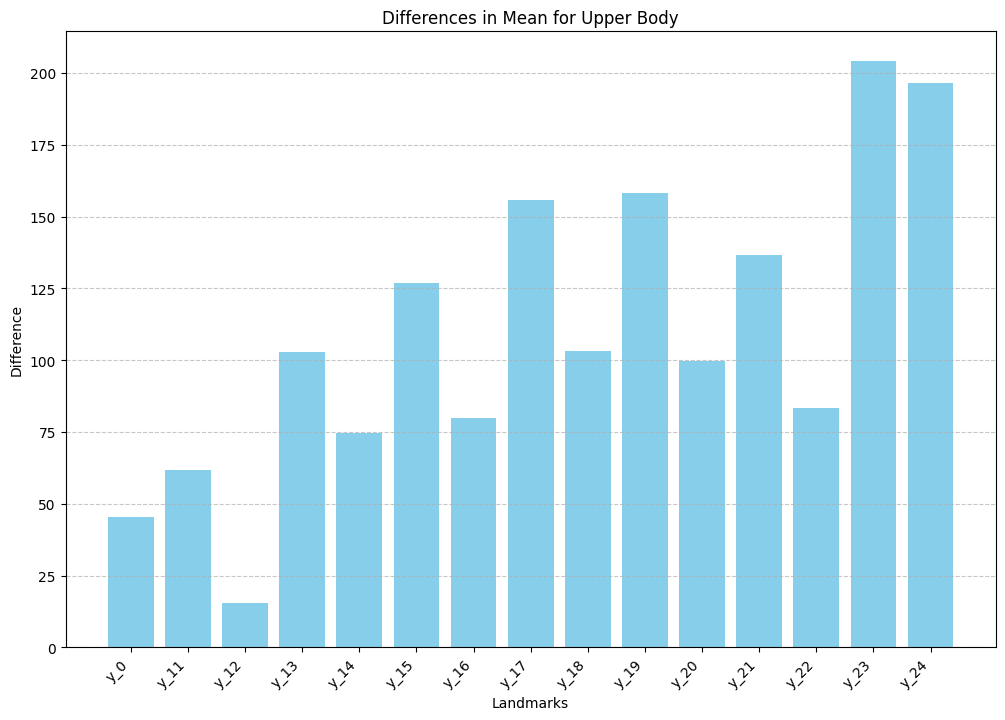

In [647]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(difference_in_mean_upper_body_02_Y.index, difference_in_mean_upper_body_02_Y, color='skyblue')
plt.title('Differences in Mean for Upper Body')
plt.xlabel('Landmarks')
plt.ylabel('Difference')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

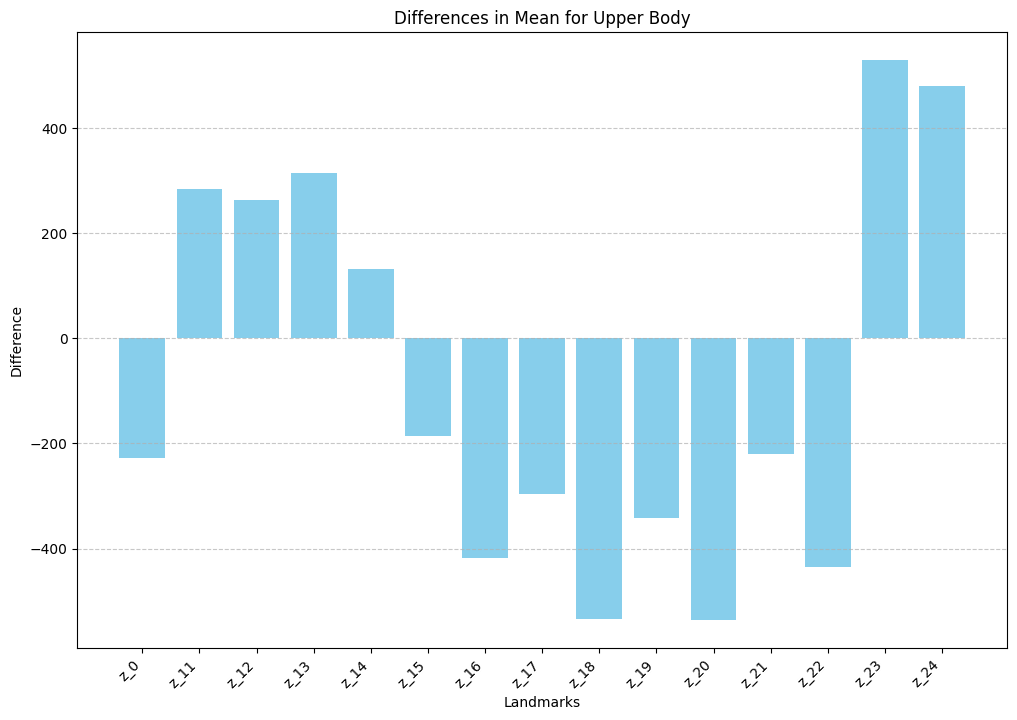

In [648]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(difference_in_mean_upper_body_02_Z.index, difference_in_mean_upper_body_02_Z, color='skyblue')
plt.title('Differences in Mean for Upper Body')
plt.xlabel('Landmarks')
plt.ylabel('Difference')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 8.3 Nicht Kompensiert 03

In [649]:
difference_in_mean_upper_body_03 = df_MediaP3[selected_columns].mean() - mean_values_03[selected_columns].mean()
print(f"Mean Value in DeepMotion 03: {difference_in_mean_upper_body_03}")

Mean Value in DeepMotion 03: x_0     -79.727432
y_0     -12.878601
z_0    -215.486841
x_11     40.958609
y_11     96.163076
z_11    421.896135
x_12   -219.902243
y_12     81.928650
z_12    427.840876
x_13    -13.864860
y_13    199.769663
z_13    411.117255
x_14   -198.952793
y_14    176.548532
z_14    145.939174
x_15    -12.935756
y_15    265.261322
z_15   -157.637703
x_16   -149.607376
y_16    174.598473
z_16   -581.207535
x_17    -16.636216
y_17    298.852667
z_17   -310.012186
x_18   -134.422691
y_18    188.485895
z_18   -749.404108
x_19    -19.505289
y_19    286.740996
z_19   -335.861554
x_20   -138.045069
y_20    176.511838
z_20   -732.746303
x_21    -25.007999
y_21    268.128056
z_21   -187.053607
x_22   -134.235969
y_22    157.867234
z_22   -592.268149
x_23    -42.196064
y_23    270.904955
z_23    667.807884
x_24   -147.509207
y_24    273.400205
z_24    721.503507
dtype: float64


In [650]:
difference_in_mean_upper_body_03_X = difference_in_mean_upper_body_03[selected_columns_X]
difference_in_mean_upper_body_03_Y = difference_in_mean_upper_body_03[selected_columns_Y]
difference_in_mean_upper_body_03_Z = difference_in_mean_upper_body_03[selected_columns_Z]

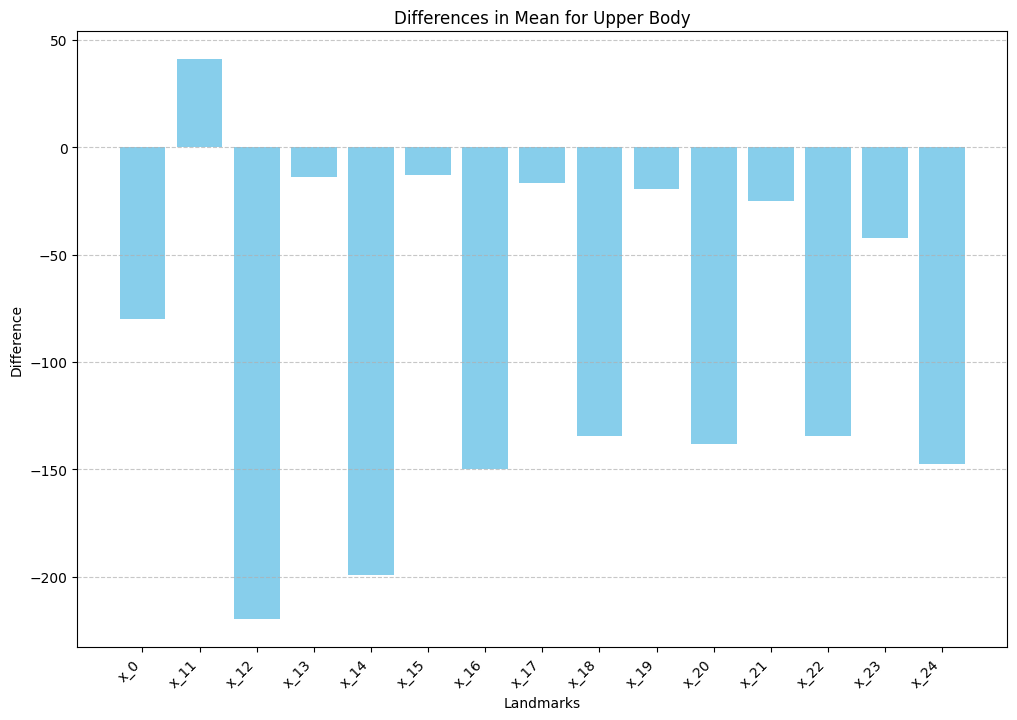

In [651]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(difference_in_mean_upper_body_03_X.index, difference_in_mean_upper_body_03_X, color='skyblue')
plt.title('Differences in Mean for Upper Body')
plt.xlabel('Landmarks')
plt.ylabel('Difference')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

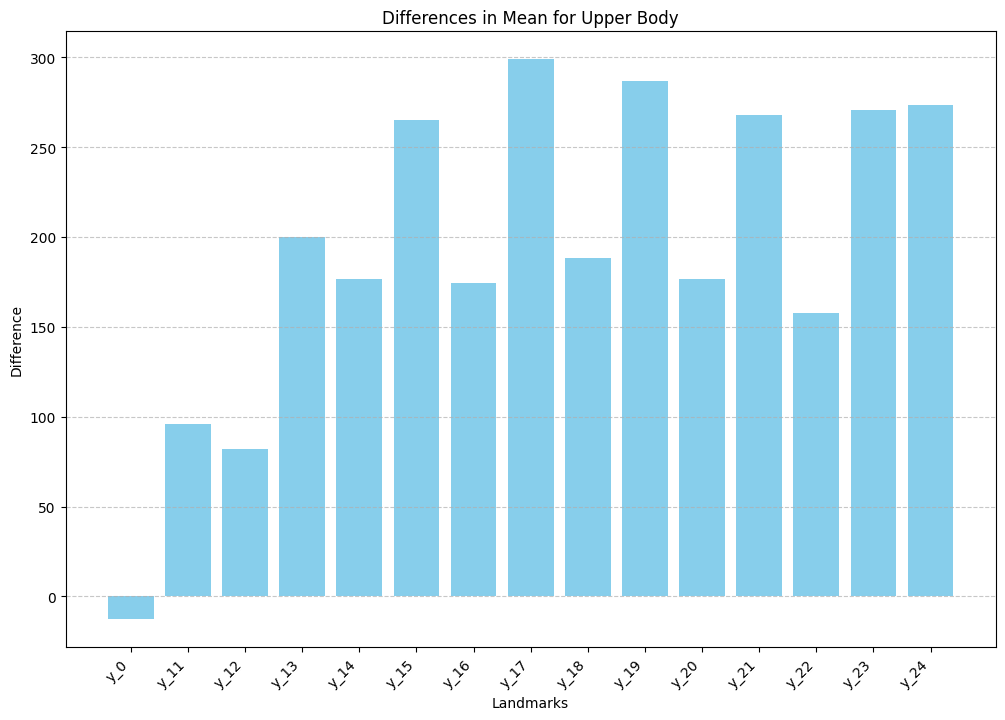

In [652]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(difference_in_mean_upper_body_03_Y.index, difference_in_mean_upper_body_03_Y, color='skyblue')
plt.title('Differences in Mean for Upper Body')
plt.xlabel('Landmarks')
plt.ylabel('Difference')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

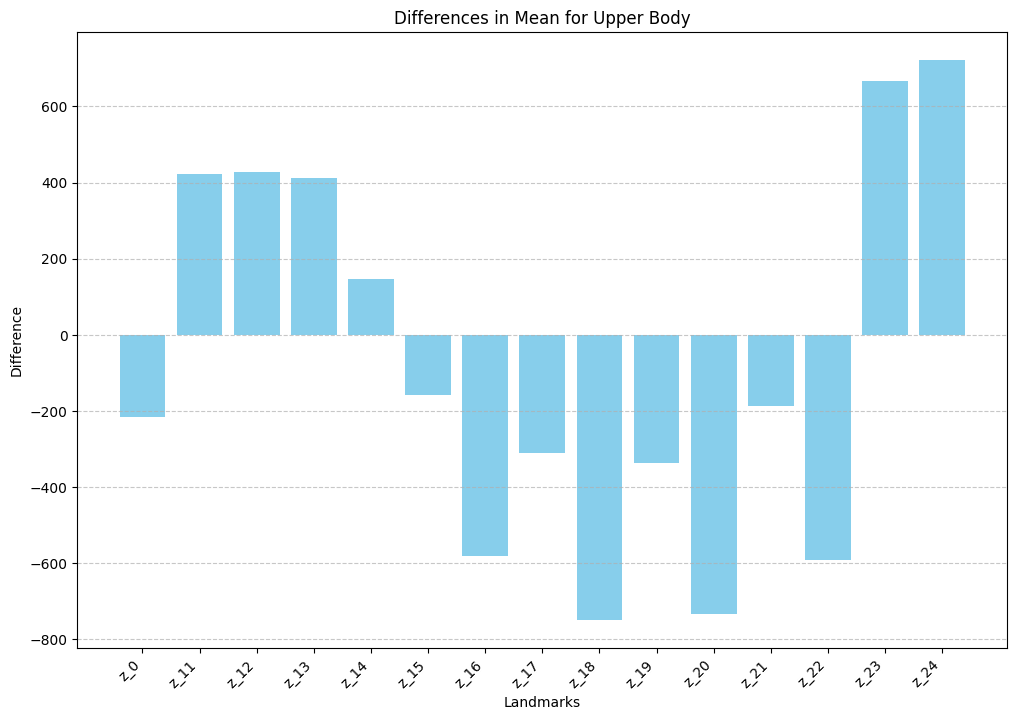

In [653]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(difference_in_mean_upper_body_03_Z.index, difference_in_mean_upper_body_03_Z, color='skyblue')
plt.title('Differences in Mean for Upper Body')
plt.xlabel('Landmarks')
plt.ylabel('Difference')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()